--- SUMMARY STATISTICS (End of Period) ---
Final Buyer Net Worth:   $1,147,031.60
Final Renter Net Worth:  $1,142,276.24
Winner: BUYING by $4,755.37
Buying became financially superior in Year: 23.6


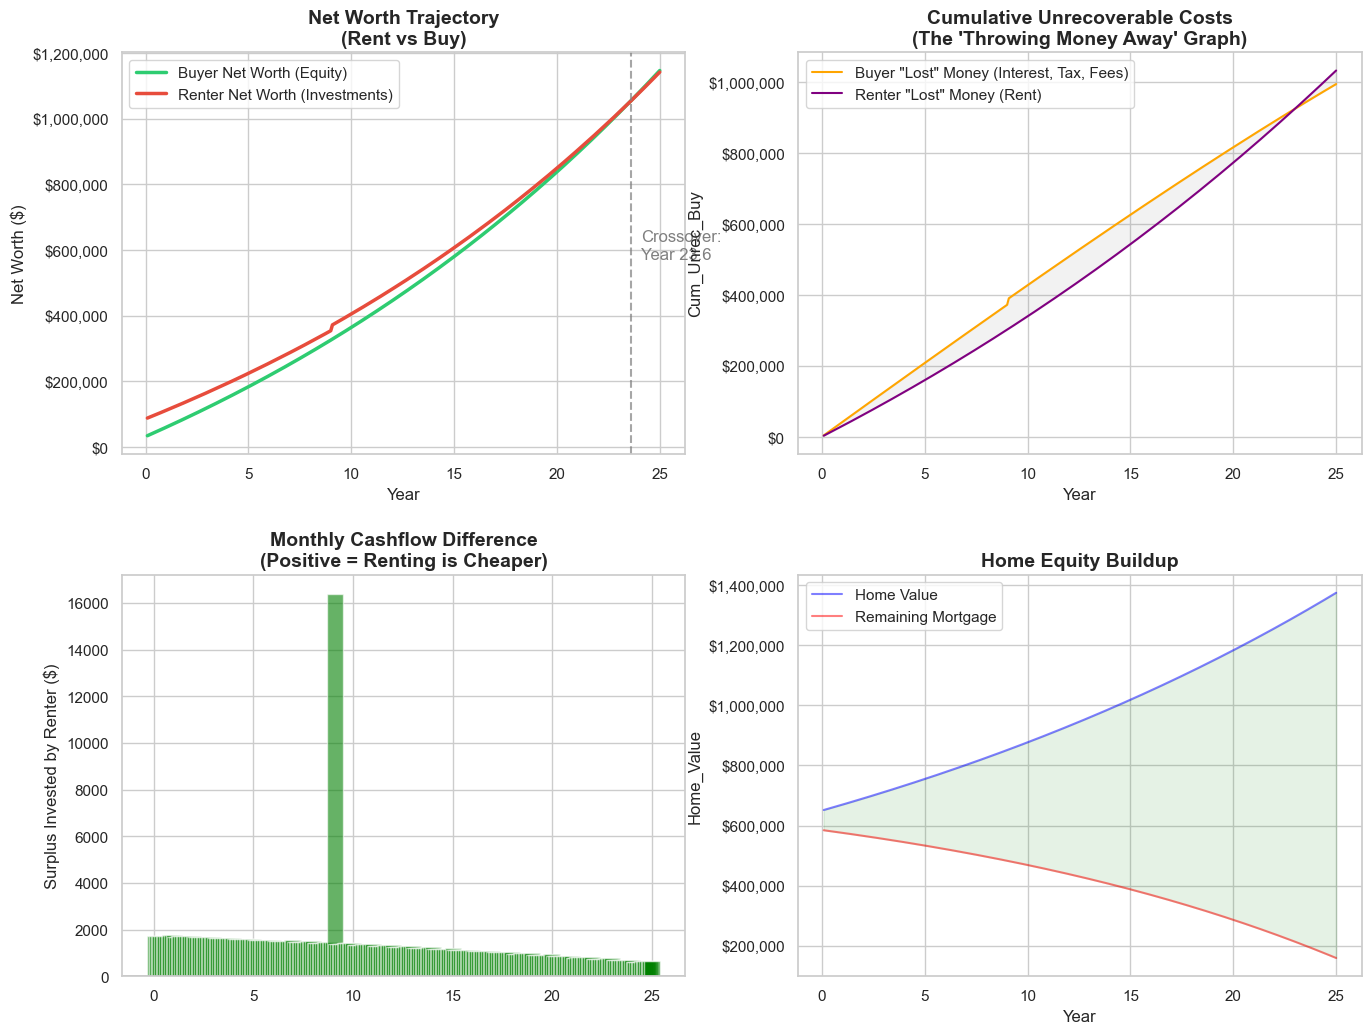

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# --- CONFIGURATION (TUNE THESE PARAMETERS) ---

# SCENARIO: TORONTO CONDO
PARAMS = {
    # --- Market / Economic ---
    'forecast_years': 25,
    'inflation_rate': 0.02,           # General inflation (affects maintenance, fees)
    'investment_return': 0.05,        # 5% Conservative GIC/ETF Blended Return
    'mortgage_rate': 0.045,           # 4.5% 5-Year Fixed equivalent

    # --- Property (The Buy) ---
    'home_price': 650000,
    'down_payment_percent': 0.10,     # 20% to avoid CMHC insurance
    'amortization_years': 30,
    'appreciation_rate': 0.03,        # Conservative 3% annual growth
    'property_tax_rate': 0.0061,      # Approx Toronto rate (~0.61%)
    'maintenance_annual_percent': 0.005, # 0.5% of value for Condo (lower than house due to fees)
    'condo_fees_monthly': 650,        # Monthly Maintenance Fees
    'home_insurance_monthly': 50,     # Condo insurance is usually cheaper
    'selling_cost_percent': 0.05,     # Realtor fees + Legal to sell at end of period

    # --- Special Assessments (The "Gotcha" Cost) ---
    # Dictionary: {Year: Amount}
    'special_assessments': {
        10: 15000  # e.g., Window replacement or Elevator refit in Year 10
        # 20: 10000   # e.g., Hallway refurbishment in Year 20
    },

    # --- Rental (The Alternative) ---
    'current_monthly_rent': 2500,
    'rent_insurance_monthly': 30,
    'rent_increase_annual': 0.025,    # 2.5% Guideline
}

# --- HELPER FUNCTIONS ---

def calculate_toronto_ltt(price):
    """
    Calculates Land Transfer Tax for Toronto (Municipal + Provincial).
    """
    def bracket_calc(val):
        tax = 0
        # Provincial
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax

    # Toronto generally mirrors Provincial + administration fee, effectively double
    # This is a simplification but accurate enough for modeling
    provincial = bracket_calc(price)
    municipal = bracket_calc(price) 
    
    # First time buyer rebate is ignored here for conservative estimate, 
    # but could be subtracted (~$8k total max)
    return provincial + municipal

def run_simulation(p):
    # Setup
    months = p['forecast_years'] * 12
    
    # Initial Capital Requirements
    down_payment = p['home_price'] * p['down_payment_percent']
    mortgage_principal = p['home_price'] - down_payment
    ltt = calculate_toronto_ltt(p['home_price'])
    legal_misc = 2500
    
    initial_cash_outlay = down_payment + ltt + legal_misc
    
    # Lists to store time-series data
    data = []
    
    # Running values
    r_portfolio = initial_cash_outlay # Renter invests the downpayment + closing costs
    b_home_value = p['home_price']
    b_mortgage_balance = mortgage_principal
    
    # Mortgage Calculation (Monthly Payment)
    monthly_rate = p['mortgage_rate'] / 12
    n_payments = p['amortization_years'] * 12
    mortgage_payment = (mortgage_principal * monthly_rate * (1 + monthly_rate)**n_payments) / ((1 + monthly_rate)**n_payments - 1)
    
    current_rent = p['current_monthly_rent']
    current_condo_fee = p['condo_fees_monthly']
    current_maintenance_calc = (p['home_price'] * p['maintenance_annual_percent']) / 12
    
    for m in range(1, months + 1):
        year = (m-1) // 12 + 1
        
        # --- BUYER COSTS ---
        # 1. Mortgage Split
        interest_payment = b_mortgage_balance * monthly_rate
        principal_payment = mortgage_payment - interest_payment
        if b_mortgage_balance <= 0:
            interest_payment = 0
            principal_payment = 0
            mortgage_payment_actual = 0
        else:
            mortgage_payment_actual = mortgage_payment
        
        b_mortgage_balance -= principal_payment
        
        # 2. Other Owner Costs
        prop_tax = (b_home_value * p['property_tax_rate']) / 12
        # Maintenance scales with inflation, not home value directly (usually)
        maint = current_maintenance_calc * ((1 + p['inflation_rate'])**((m-1)/12))
        
        # Check for Special Assessment
        special_assessment = p['special_assessments'].get(year, 0) if m % 12 == 1 else 0
        
        total_buy_cost = (
            mortgage_payment_actual + 
            prop_tax + 
            current_condo_fee + 
            p['home_insurance_monthly'] + 
            maint + 
            special_assessment
        )
        
        # "Unrecoverable" Buy Costs (Money burnt)
        unrecoverable_buy = (
            interest_payment + 
            prop_tax + 
            current_condo_fee + 
            p['home_insurance_monthly'] + 
            maint + 
            special_assessment
        )

        # --- RENTER COSTS ---
        total_rent_cost = current_rent + p['rent_insurance_monthly']
        
        # --- THE DIFFERENCE (OPPORTUNITY COST) ---
        monthly_surplus = total_buy_cost - total_rent_cost
        
        # Update Renter Portfolio
        # Renter earns monthly return on existing portfolio
        r_portfolio *= (1 + p['investment_return']/12)
        
        # If Buying is cheaper, Buyer invests the savings. If Renting cheaper, Renter invests.
        # We track Renter Net Worth, so if Surplus > 0 (Buy is expensive), Renter invests that amount.
        # If Surplus < 0 (Buy is cheaper), Renter effectively withdraws (or Buyer gains, modeled as Renter losing relative value)
        r_portfolio += monthly_surplus
        
        # --- ASSET UPDATES ---
        b_home_value *= (1 + p['appreciation_rate']/12)
        
        # Yearly updates (Inflation / Rent Increases)
        if m % 12 == 0:
            current_rent *= (1 + p['rent_increase_annual'])
            current_condo_fee *= (1 + p['inflation_rate'])
        
        # --- STORE DATA ---
        # Buyer Net Worth = Home Value - Mortgage - Selling Fees (5%)
        # Note: We apply selling fees to see the "Liquid" value
        buyer_net_worth = b_home_value - b_mortgage_balance - (b_home_value * p['selling_cost_percent'])
        
        data.append({
            'Month': m,
            'Year': m/12,
            'Buyer_Net_Worth': buyer_net_worth,
            'Renter_Net_Worth': r_portfolio,
            'Unrecoverable_Buy': unrecoverable_buy,
            'Unrecoverable_Rent': total_rent_cost,
            'Home_Value': b_home_value,
            'Mortgage_Balance': b_mortgage_balance,
            'Cashflow_Difference': monthly_surplus # Positive means Renting is cheaper cashflow
        })
        
    return pd.DataFrame(data)

# --- EXECUTION & VISUALIZATION ---

df = run_simulation(PARAMS)
crossover = df.loc[df['Buyer_Net_Worth'] > df['Renter_Net_Worth']]
crossover_point = crossover.iloc[0]['Year'] if not crossover.empty else None

# Set Style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# 1. NET WORTH COMPARISON
ax1 = axes[0, 0]
sns.lineplot(data=df, x='Year', y='Buyer_Net_Worth', ax=ax1, label='Buyer Net Worth (Equity)', linewidth=2.5, color='#2ecc71')
sns.lineplot(data=df, x='Year', y='Renter_Net_Worth', ax=ax1, label='Renter Net Worth (Investments)', linewidth=2.5, color='#e74c3c')
ax1.set_title(f"Net Worth Trajectory\n(Rent vs Buy)", fontsize=14, weight='bold')
ax1.set_ylabel("Net Worth ($)")
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
if crossover_point:
    ax1.axvline(crossover_point, color='gray', linestyle='--', alpha=0.7)
    ax1.text(crossover_point + 0.5, df['Buyer_Net_Worth'].max()*0.5, f'Crossover:\nYear {crossover_point:.1f}', color='gray')

# 2. CUMULATIVE UNRECOVERABLE COSTS
# "Throwing money away" comparison
df['Cum_Unrec_Buy'] = df['Unrecoverable_Buy'].cumsum()
df['Cum_Unrec_Rent'] = df['Unrecoverable_Rent'].cumsum()

ax2 = axes[0, 1]
sns.lineplot(data=df, x='Year', y='Cum_Unrec_Buy', ax=ax2, label='Buyer "Lost" Money (Interest, Tax, Fees)', color='orange')
sns.lineplot(data=df, x='Year', y='Cum_Unrec_Rent', ax=ax2, label='Renter "Lost" Money (Rent)', color='purple')
ax2.fill_between(df['Year'], df['Cum_Unrec_Buy'], df['Cum_Unrec_Rent'], alpha=0.1, color='gray')
ax2.set_title("Cumulative Unrecoverable Costs\n(The 'Throwing Money Away' Graph)", fontsize=14, weight='bold')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# 3. MONTHLY CASHFLOW DIFFERENCE
# Shows how much the Renter invests monthly
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in df['Cashflow_Difference']]
ax3.bar(df['Year'], df['Cashflow_Difference'], color=colors, alpha=0.6, width=0.8)
ax3.axhline(0, color='black', linewidth=1)
ax3.set_title("Monthly Cashflow Difference\n(Positive = Renting is Cheaper)", fontsize=14, weight='bold')
ax3.set_ylabel("Surplus Invested by Renter ($)")

# 4. EQUITY BUILDUP
ax4 = axes[1, 1]
sns.lineplot(data=df, x='Year', y='Home_Value', ax=ax4, label='Home Value', color='blue', alpha=0.5)
sns.lineplot(data=df, x='Year', y='Mortgage_Balance', ax=ax4, label='Remaining Mortgage', color='red', alpha=0.5)
ax4.fill_between(df['Year'], df['Home_Value'], df['Mortgage_Balance'], color='green', alpha=0.1, label='Home Equity')
ax4.set_title("Home Equity Buildup", fontsize=14, weight='bold')
ax4.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Summary Statistics
print("--- SUMMARY STATISTICS (End of Period) ---")
print(f"Final Buyer Net Worth:   ${df.iloc[-1]['Buyer_Net_Worth']:,.2f}")
print(f"Final Renter Net Worth:  ${df.iloc[-1]['Renter_Net_Worth']:,.2f}")
diff = df.iloc[-1]['Buyer_Net_Worth'] - df.iloc[-1]['Renter_Net_Worth']
winner = "BUYING" if diff > 0 else "RENTING"
print(f"Winner: {winner} by ${abs(diff):,.2f}")
if crossover_point:
    print(f"Buying became financially superior in Year: {crossover_point:.1f}")
else:
    print("Buying never exceeded Renting performance in this timeframe.")

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. CONFIGURATION ---
PARAMS = {
    # --- Profile ---
    'salary': 120000,                 # Annual household income
    'salary_growth': 0.03,            # 3% Annual raise
    'is_first_time_buyer': True,      # Toggles LTT Rebates
    
    # --- Tax Shelters ---
    'initial_registered_room': 100000, # Unused RRSP/TFSA room available today
    'annual_tfsa_room': 7000,         # Estimated annual TFSA increase
    'investment_tax_rate': 0.25,      # Tax rate on UNREGISTERED gains
    
    # --- Market ---
    'forecast_years': 30,             # Extended to 30 years to see the long tail
    'inflation_rate': 0.02,
    'investment_return': 0.065,       # 6.5% return (slightly more aggressive)
    'mortgage_rate': 0.045,           # 4.5% Fixed
    
    # --- Property ---
    'home_price': 750000,
    'down_payment_percent': 0.20,
    'amortization_years': 25,
    'appreciation_rate': 0.03,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'home_insurance_monthly': 50,
    'maintenance_annual_percent': 0.005,
    'selling_cost_percent': 0.05,
    'special_assessments': { 10: 15000, 20: 15000, 25: 20000 }, # Added Year 25 hit

    # --- Rental ---
    'current_monthly_rent': 2800,
    'rent_insurance_monthly': 30,
    'rent_increase_annual': 0.025,
    'surplus_invested_pct': 0.85,     # Invest 85% of savings
}

# --- 2. CALCULATORS ---

def calculate_toronto_ltt(price, is_fthb):
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    provincial = bracket(price)
    municipal = bracket(price)
    if is_fthb:
        provincial = max(0, provincial - 4000)
        municipal = max(0, municipal - 4475)
    return provincial + municipal

def run_simulation(p):
    months = p['forecast_years'] * 12
    
    # Initial Setup
    down_payment = p['home_price'] * p['down_payment_percent']
    ltt = calculate_toronto_ltt(p['home_price'], p['is_first_time_buyer'])
    closing_costs = ltt + 2000 
    initial_cash = down_payment + closing_costs
    
    # Renter Initial Pot
    renter_reg_bal = 0
    renter_unreg_bal = 0
    current_reg_room = p['initial_registered_room']
    
    if initial_cash <= current_reg_room:
        renter_reg_bal = initial_cash
        current_reg_room -= initial_cash
    else:
        renter_reg_bal = current_reg_room
        renter_unreg_bal = initial_cash - current_reg_room
        current_reg_room = 0
    
    # Mortgage Setup
    r_monthly = p['mortgage_rate'] / 12
    n_payments = p['amortization_years'] * 12
    mortgage_princ = p['home_price'] - down_payment
    mortgage_payment = (mortgage_princ * r_monthly * (1 + r_monthly)**n_payments) / ((1 + r_monthly)**n_payments - 1)
    
    # State Variables
    b_home_value = p['home_price']
    b_mortgage_balance = mortgage_princ
    current_salary = p['salary']
    
    # Dynamic Expenses
    curr_rent = p['current_monthly_rent']
    curr_condo_fee = p['condo_fees_monthly']
    curr_maint_base = (p['home_price'] * p['maintenance_annual_percent']) / 12
    
    records = []
    
    # Track annual totals for the salary chart
    annual_new_room = 0
    annual_contribution = 0
    
    for m in range(1, months + 1):
        year = (m-1) // 12 + 1
        
        # --- BUYER ---
        interest = b_mortgage_balance * r_monthly
        principal = mortgage_payment - interest
        if b_mortgage_balance <= 0: interest, principal, pay_actual = 0, 0, 0
        else: pay_actual = mortgage_payment
        b_mortgage_balance -= principal
        
        prop_tax = (b_home_value * p['property_tax_rate']) / 12
        maint = curr_maint_base * ((1 + p['inflation_rate'])**((m-1)/12))
        spec_assessment = p['special_assessments'].get(year, 0) if m % 12 == 1 else 0
        
        cost_buy = pay_actual + prop_tax + curr_condo_fee + p['home_insurance_monthly'] + maint + spec_assessment
        
        # --- RENTER ---
        cost_rent = curr_rent + p['rent_insurance_monthly']
        
        # --- CASHFLOW GAP ---
        monthly_gap = cost_buy - cost_rent
        
        # --- INVESTING ---
        inv_growth = p['investment_return'] / 12
        renter_reg_bal *= (1 + inv_growth)
        renter_unreg_bal *= (1 + (inv_growth * (1 - p['investment_tax_rate'])))
        
        contribution_this_month = 0
        
        if monthly_gap > 0:
            investable = monthly_gap * p['surplus_invested_pct']
            
            # Fill Registered Room First
            if investable <= current_reg_room:
                renter_reg_bal += investable
                current_reg_room -= investable
                contribution_this_month = investable
            else:
                contribution_this_month = current_reg_room # We maxed it out
                top_up = current_reg_room
                spillover = investable - current_reg_room
                renter_reg_bal += top_up
                renter_unreg_bal += spillover
                current_reg_room = 0
        else:
            # Renter deficit (Rent > Buy cost)
            deficit = abs(monthly_gap)
            if renter_unreg_bal >= deficit:
                renter_unreg_bal -= deficit
            else:
                rem = deficit - renter_unreg_bal
                renter_unreg_bal = 0
                renter_reg_bal -= rem
        
        annual_contribution += contribution_this_month

        # --- ANNUAL UPDATES ---
        if m % 12 == 0:
            # Asset Inflation
            b_home_value *= (1 + p['appreciation_rate'])
            curr_rent *= (1 + p['rent_increase_annual'])
            curr_condo_fee *= (1 + p['inflation_rate'])
            
            # Salary & Tax Room Update
            current_salary *= (1 + p['salary_growth'])
            new_rrsp_room = min(current_salary * 0.18, 32000) # 2025ish Cap
            total_new_room = new_rrsp_room + p['annual_tfsa_room']
            current_reg_room += total_new_room
            
            # Reset annual trackers for the chart (snapshotting)
            annual_new_room = total_new_room 
            
            # Monthly smooth appreciation for chart
        
        if m % 12 != 0:
             b_home_value = p['home_price'] * ((1 + p['appreciation_rate'])**(m/12))
        
        b_equity = b_home_value - b_mortgage_balance - (b_home_value * p['selling_cost_percent'])
        
        records.append({
            'Year': m/12,
            'Buyer Net Worth': b_equity,
            'Renter Net Worth': renter_reg_bal + renter_unreg_bal,
            'Cashflow Surplus': monthly_gap,
            'Salary': current_salary,
            'New Tax Room Generated': annual_new_room if m % 12 == 0 else np.nan,
            'Annual Contribution': annual_contribution if m % 12 == 0 else np.nan
        })
        
        if m % 12 == 0:
            annual_contribution = 0 # Reset for next year

    return pd.DataFrame(records)

# --- 3. DASHBOARD ---
df = run_simulation(PARAMS)
df_annual = df.dropna(subset=['New Tax Room Generated']) # Filter for annual bars

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Net Worth Race (Equity vs Investments)", 
        "Monthly Cashflow Surplus (Renter's Edge)", 
        "Salary Growth (The Engine)",
        "Tax Shelter Efficiency (Room vs Contribution)"
    ),
    vertical_spacing=0.15,
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]]
)

# 1. Net Worth (Top Left)
fig.add_trace(go.Scatter(x=df['Year'], y=df['Buyer Net Worth'], name='Buyer Equity', line=dict(color='#00cc96', width=3)), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Year'], y=df['Renter Net Worth'], name='Renter Portfolio', line=dict(color='#EF553B', width=3)), row=1, col=1)

# 2. Monthly Surplus (Top Right - Swapped for visibility)
colors = ['#00cc96' if x < 0 else '#EF553B' for x in df['Cashflow Surplus']]
fig.add_trace(go.Bar(x=df['Year'], y=df['Cashflow Surplus'], marker_color=colors, name='Monthly Surplus ($)', opacity=0.5), row=1, col=2)
# Add Zero Line
fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=2)

# 3. Salary Growth (Bottom Left)
fig.add_trace(go.Scatter(x=df['Year'], y=df['Salary'], name='Annual Salary', line=dict(color='#636EFA', width=3)), row=2, col=1)

# 4. Tax Shelter Efficiency (Bottom Right)
fig.add_trace(go.Bar(x=df_annual['Year'], y=df_annual['New Tax Room Generated'], name='New TFSA/RRSP Room', marker_color='lightgray'), row=2, col=2)
fig.add_trace(go.Bar(x=df_annual['Year'], y=df_annual['Annual Contribution'], name='Actual Contribution', marker_color='#AB63FA'), row=2, col=2)

fig.update_layout(height=800, width=1200, title_text="Rent vs. Buy: Income & Asset Model", template="plotly_white")
fig.show()

In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. CONFIGURATION ---
PARAMS = {
    # --- Profile ---
    'salary': 120000,                 # Annual Household Income (Gross)
    'salary_growth': 0.03,            # Annual Raise
    'average_income_tax_rate': 0.28,  # Approx effective tax rate (Fed + Prov)
    'living_expenses_monthly': 1500,  # Food, Transport, Life (After tax)
    'living_expense_growth': 0.02,
    
    # --- Renter Strategy ---
    # The Renter invests this % of their GROSS salary every month.
    # PLUS they invest the initial downpayment/closing costs at Year 0.
    'renter_fixed_investment_pct': 0.3, 
    
    # --- Tax Shelters ---
    'initial_tfsa_room': 80000,
    'initial_rrsp_room': 50000,
    'annual_tfsa_room': 7000,
    'investment_tax_rate': 0.25,      # Tax on Unregistered Capital Gains
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.05,        # 5% Market Return
    'inflation_rate': 0.02,
    
    # --- Property (The Buy) ---
    'home_price': 650000,
    'down_payment_percent': 0.10,
    'mortgage_rate': 0.045,           # 4.5% Fixed
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'home_insurance_monthly': 50,
    'maintenance_annual_percent': 0.005,
    'selling_cost_percent': 0.05,
    'is_first_time_buyer': True,
    'appreciation_rate': 0.02,

    # --- Rental (The Alternative) ---
    'current_monthly_rent': 2600,
    'rent_insurance_monthly': 30,
    'rent_increase_annual': 0.025,
}

# --- 2. LOGIC ENGINE ---

def calculate_ltt(price, is_fthb):
    """Toronto Double LTT with Rebates"""
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def run_scenario(p, role):
    months = p['forecast_years'] * 12
    
    # -- Initialize Financials --
    current_gross_salary = p['salary'] / 12 
    living_expenses = p['living_expenses_monthly']
    
    tfsa_room = p['initial_tfsa_room']
    rrsp_room = p['initial_rrsp_room']
    
    # Portfolios
    tfsa_bal = 0
    rrsp_bal = 0
    unreg_bal = 0
    
    # -- Initial Capital Logic --
    # Calculate the cash required to close the deal (Downpayment + LTT + Legal)
    ltt = calculate_ltt(p['home_price'], p['is_first_time_buyer'])
    closing_cash_req = (p['home_price'] * p['down_payment_percent']) + ltt + 2000
    
    if role == 'RENTER':
        # Renter INVESTS this lump sum immediately
        capital_to_deploy = closing_cash_req
        
        # Waterfall: Max TFSA -> Max RRSP -> Unregistered
        if capital_to_deploy <= tfsa_room:
            tfsa_bal = capital_to_deploy
            tfsa_room -= capital_to_deploy
            capital_to_deploy = 0
        else:
            tfsa_bal = tfsa_room
            capital_to_deploy -= tfsa_room
            tfsa_room = 0
            
        if capital_to_deploy > 0:
            if capital_to_deploy <= rrsp_room:
                rrsp_bal = capital_to_deploy
                rrsp_room -= capital_to_deploy
                capital_to_deploy = 0
            else:
                rrsp_bal = rrsp_room
                capital_to_deploy -= rrsp_room
                rrsp_room = 0
                
        unreg_bal = capital_to_deploy
        
        # Mortgage Setup (Not used by renter, but init for code safety)
        b_home_val = 0
        b_mort_bal = 0
        mort_pymt = 0
        r_mo = 0
        curr_rent = p['current_monthly_rent']
        
    else: # BUYER
        # Buyer SPENDS this lump sum
        # Setup Mortgage
        r_mo = p['mortgage_rate'] / 12
        n_pay = p['amortization_years'] * 12
        mort_princ = p['home_price'] - (p['home_price'] * p['down_payment_percent'])
        mort_pymt = (mort_princ * r_mo * (1 + r_mo)**n_pay) / ((1 + r_mo)**n_pay - 1)
        
        b_home_val = p['home_price']
        b_mort_bal = mort_princ

    records = []

    for m in range(1, months + 1):
        year = (m-1) // 12 + 1
        
        # 1. Growth
        inv_growth = p['investment_return'] / 12
        tfsa_bal *= (1 + inv_growth)
        rrsp_bal *= (1 + inv_growth)
        unreg_bal *= (1 + (inv_growth * (1 - p['investment_tax_rate']))) 
        
        # 2. Costs
        housing_cost = 0
        
        if role == 'BUYER':
            # Mortgage Interest/Principal
            interest = b_mort_bal * r_mo
            principal = mort_pymt - interest
            if b_mort_bal <= 0: interest, principal, act_pay = 0, 0, 0
            else: act_pay = mort_pymt
            b_mort_bal -= principal
            
            # Fees
            prop_tax = (b_home_val * p['property_tax_rate']) / 12
            maint = ((p['home_price'] * p['maintenance_annual_percent']) / 12) * ((1 + p['inflation_rate'])**((m-1)/12))
            housing_cost = act_pay + prop_tax + p['condo_fees_monthly'] + p['home_insurance_monthly'] + maint
            
        else: # RENTER
            housing_cost = curr_rent + p['rent_insurance_monthly']

        # 3. Budgeting (Where does the salary go?)
        # Gross Salary -> Tax -> Housing -> Living -> Savings -> Leftover
        
        income_tax = current_gross_salary * p['average_income_tax_rate']
        net_income = current_gross_salary - income_tax
        
        # Determine Investment Amount
        target_investment = 0
        if role == 'RENTER':
            # Fixed % of GROSS salary
            target_investment = current_gross_salary * p['renter_fixed_investment_pct']
        else:
            # Buyer invests whatever is left
            surplus = net_income - housing_cost - living_expenses
            target_investment = max(0, surplus)
            
        # Affordability Check
        # Can we actually afford this investment?
        actual_investment = 0
        available_cash = net_income - housing_cost - living_expenses
        
        if available_cash >= target_investment:
            actual_investment = target_investment
            remaining_cash = available_cash - target_investment
        else:
            # We are short!
            actual_investment = max(0, available_cash) # Invest what we can (if any)
            remaining_cash = 0 # Wallet is empty
            
            # If available_cash is negative, we are in debt (represented as negative remaining_cash)
            if available_cash < 0:
                remaining_cash = available_cash 

        # 4. Deploy Investments (Waterfall)
        to_invest = actual_investment
        
        if to_invest > 0:
            # TFSA
            take = min(to_invest, tfsa_room)
            tfsa_bal += take
            tfsa_room -= take
            to_invest -= take
            
            # RRSP
            if to_invest > 0:
                take = min(to_invest, rrsp_room)
                rrsp_bal += take
                rrsp_room -= take
                to_invest -= take
            
            # Unregistered
            if to_invest > 0:
                unreg_bal += to_invest

        # 5. Net Worth Calc
        liquid_assets = tfsa_bal + rrsp_bal + unreg_bal
        home_equity = 0
        if role == 'BUYER':
            home_equity = b_home_val - b_mort_bal - (b_home_val * p['selling_cost_percent'])
            
        total_nw = liquid_assets + home_equity
        
        records.append({
            'Year': m/12,
            'Role': role,
            'Net Worth': total_nw,
            'Gross Salary': current_gross_salary,
            'Income Tax': income_tax,
            'Housing Cost': housing_cost,
            'Living Expenses': living_expenses,
            'Invested': actual_investment,
            'Remaining Cash': remaining_cash,
            'Home Equity': home_equity,
            'Liquid Assets': liquid_assets,
            'TFSA': tfsa_bal,
            'RRSP': rrsp_bal,
            'Taxable': unreg_bal
        })
        
        # 6. Annual Updates
        if m % 12 == 0:
            current_gross_salary *= (1 + p['salary_growth'])
            living_expenses *= (1 + p['living_expense_growth'])
            
            # New Room
            tfsa_room += p['annual_tfsa_room']
            # RRSP is based on PREVIOUS year earned income (approx)
            new_rrsp = min(current_gross_salary * 12 * 0.18, 32000) 
            rrsp_room += new_rrsp
            
            if role == 'BUYER':
                b_home_val *= (1 + p['appreciation_rate'])
                p['condo_fees_monthly'] *= (1 + p['inflation_rate'])
            else:
                curr_rent *= (1 + p['rent_increase_annual'])

    return pd.DataFrame(records)

# --- 3. EXECUTION ---
df_b = run_scenario(PARAMS, 'BUYER')
df_r = run_scenario(PARAMS, 'RENTER')

# --- 4. VISUALIZATION ---
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Net Worth Comparison (Rent vs Buy)", 
        "Budget Flow: Where does the Salary Go? (Buyer)", 
        "Budget Flow: Where does the Salary Go? (Renter)",
        "Renter Portfolio Strategy"
    ),
    horizontal_spacing=0.08, vertical_spacing=0.15
)

# 1. Net Worth (Top Left)
fig.add_trace(go.Scatter(x=df_b['Year'], y=df_b['Net Worth'], name='Buyer Net Worth', line=dict(color='#00cc96', width=3)), row=1, col=1)
fig.add_trace(go.Scatter(x=df_r['Year'], y=df_r['Net Worth'], name='Renter Net Worth', line=dict(color='#EF553B', width=3)), row=1, col=1)

# 2 & 3. Budget Flow (Stacked Area - "Timeline Sankey")
def add_budget_stack(df, row, col, show_legend=False):
    # We use 'stackgroup' to stack them perfectly
    x = df['Year']
    fig.add_trace(go.Scatter(x=x, y=df['Income Tax'], name='Income Tax', stackgroup='A', line=dict(width=0, color='gray'), showlegend=show_legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=x, y=df['Living Expenses'], name='Living Expenses', stackgroup='A', line=dict(width=0, color='#FFA15A'), showlegend=show_legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=x, y=df['Housing Cost'], name='Housing', stackgroup='A', line=dict(width=0, color='#EF553B'), showlegend=show_legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=x, y=df['Invested'], name='Investments', stackgroup='A', line=dict(width=0, color='#00cc96'), showlegend=show_legend), row=row, col=col)
    # Remaining Cash helps us see if we are "under water" (if negative, we don't plot it here, handled in logic)
    fig.add_trace(go.Scatter(x=x, y=df['Remaining Cash'].clip(lower=0), name='Unspent Cash', stackgroup='A', line=dict(width=0, color='#AB63FA'), showlegend=show_legend), row=row, col=col)

add_budget_stack(df_b, 1, 2, show_legend=True) # Buyer
add_budget_stack(df_r, 2, 1, show_legend=False) # Renter (Share legend colors)

# 4. Renter Portfolio Breakdown (Bottom Right)
fig.add_trace(go.Scatter(x=df_r['Year'], y=df_r['TFSA'], name='TFSA (Tax Free)', stackgroup='B', line=dict(width=0, color='#636EFA')), row=2, col=2)
fig.add_trace(go.Scatter(x=df_r['Year'], y=df_r['RRSP'], name='RRSP (Deferred)', stackgroup='B', line=dict(width=0, color='#AB63FA')), row=2, col=2)
fig.add_trace(go.Scatter(x=df_r['Year'], y=df_r['Taxable'], name='Taxable Account', stackgroup='B', line=dict(width=0, color='#FFA15A')), row=2, col=2)

fig.update_layout(height=1000, width=1300, title_text="Advanced Rent vs. Buy: Full Budget Simulation", template='plotly_white')
fig.show()

# --- 5. SUMMARY ---
b_final = df_b.iloc[-1]['Net Worth']
r_final = df_r.iloc[-1]['Net Worth']
diff = b_final - r_final
winner = "BUYER" if diff > 0 else "RENTER"

print(f"--- RESULTS ---")
print(f"Initial Lump Sum Invested by Renter: ${calculate_ltt(PARAMS['home_price'], True) + (PARAMS['home_price']*0.20) + 2000:,.0f}")
print(f"Renter Monthly Investment Strategy: {PARAMS['renter_fixed_investment_pct']*100}% of Gross Salary")
print(f"Final Buyer Net Worth:  ${b_final:,.0f}")
print(f"Final Renter Net Worth: ${r_final:,.0f}")
print(f"WINNER: {winner} by ${abs(diff):,.0f}")

--- RESULTS ---
Initial Lump Sum Invested by Renter: $142,475
Renter Monthly Investment Strategy: 30.0% of Gross Salary
Final Buyer Net Worth:  $4,198,662
Final Renter Net Worth: $3,761,165
WINNER: BUYER by $437,496


In [15]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

# --- 1. CONFIGURATION (THE "INPUTS") ---
PARAMS = {
    # --- Profile ---
    'salary': 150000,
    'salary_growth': 0.03,            # 3% Annual Raise
    'living_expenses_monthly': 1000,  # After-tax "Lifestyle" spending (Food, Fun, Transport)
    'living_expense_growth': 0.02,    # Inflation on lifestyle
    'average_income_tax_rate': 0.28,

    # --- Strategies ---
    'strategies_to_test': ['FIXED_PCT', 'MATCH_BUYER', 'MAX_AVAILABLE'],
    'renter_fixed_investment_pct': 0.30, # Used for 'FIXED_PCT' (30% of Gross)
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.06,        # 6% Market Return (Balanced)
    'inflation_rate': 0.02,
    'debt_interest_rate': 0.08,       # Interest rate if Buyer goes insolvent (Line of Credit)
    
    # --- Property ---
    'home_price': 650000,
    'down_payment_percent': 0.10,
    'mortgage_rate': 0.045,           # 4.5% Fixed Rate
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'maintenance_annual_percent': 0.005, # 0.5% Regular Maint (Painting, minor fix)
    'is_first_time_buyer': True,      # Eligible for Land Transfer Tax Rebates?
    'appreciation_rate': 0.03,        # 3% Home Value Growth
    'selling_cost_percent': 0.05,     # 5% Commission/Legal to sell
    
    # --- Monte Carlo & Risk ---
    'run_monte_carlo': True,
    'simulation_runs': 500,           # Number of alternate realities to simulate
    
    # Special Assessment Risk (The "Gotchas")
    'prob_start': 0.02,               # Start with 2% chance of assessment
    'prob_increment': 0.03,           # Risk increases by 3% every year nothing happens
    'assessment_min_cost': 5000,
    'assessment_max_cost': 30000,
    
    # --- Rental ---
    'current_monthly_rent': 2600,
    'rent_increase_annual': 0.025,
}

# --- 2. CALCULATOR ENGINE ---

def calculate_ltt(price, is_fthb):
    """Toronto Land Transfer Tax (Municipal + Provincial) with Rebates"""
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def generate_progressive_assessments(p):
    """Generates a timeline of assessment costs based on increasing probability."""
    timeline = np.zeros(p['forecast_years'])
    current_prob = p['prob_start']
    for y in range(5, p['forecast_years']): # Grace period first 5 years
        if random.random() < current_prob:
            timeline[y] = random.uniform(p['assessment_min_cost'], p['assessment_max_cost'])
            current_prob = p['prob_start'] # Reset risk
        else:
            current_prob += p['prob_increment'] # Risk grows
    return timeline

def run_timeline(p, role, strategy, market_returns=None, prop_growth=None, assessment_timeline=None):
    months = p['forecast_years'] * 12
    
    # Financial Init
    curr_salary = p['salary'] / 12
    living_ex = p['living_expenses_monthly']
    tfsa_room = p['initial_tfsa_room'] if 'initial_tfsa_room' in p else 0
    rrsp_room = p['initial_rrsp_room'] if 'initial_rrsp_room' in p else 0
    
    tfsa_bal, rrsp_bal, unreg_bal = 0, 0, 0
    debt_bal = 0 
    b_home_val = p['home_price'] if role == 'BUYER' else 0
    
    # Capital Init
    ltt = calculate_ltt(p['home_price'], p['is_first_time_buyer'])
    upfront_cash = (p['home_price'] * p['down_payment_percent']) + ltt + 2000
    
    if role == 'RENTER':
        # Renter invests upfront cash
        cap = upfront_cash
        if cap <= tfsa_room: tfsa_bal, tfsa_room = cap, tfsa_room-cap; cap=0
        else: tfsa_bal, cap, tfsa_room = tfsa_room, cap-tfsa_room, 0
        if cap > 0:
            if cap <= rrsp_room: rrsp_bal, rrsp_room = cap, rrsp_room-cap; cap=0
            else: rrsp_bal, cap, rrsp_room = rrsp_room, cap-rrsp_room, 0
        unreg_bal = cap
        
        mort_pymt, r_mo, b_mort_bal = 0, 0, 0
        curr_rent = p['current_monthly_rent']
    else: 
        r_mo = p['mortgage_rate'] / 12
        n_pay = p['amortization_years'] * 12
        mort_princ = p['home_price'] - (p['home_price'] * p['down_payment_percent'])
        mort_pymt = (mort_princ * r_mo * (1 + r_mo)**n_pay) / ((1 + r_mo)**n_pay - 1)
        b_mort_bal = mort_princ

    records = []

    for m in range(1, months + 1):
        year = (m-1) // 12
        
        # 1. Growth Factors
        m_ret = market_returns[year] if market_returns is not None else p['investment_return']
        p_grow = prop_growth[year] if prop_growth is not None else p['appreciation_rate']
        
        gf = m_ret / 12
        df = p['debt_interest_rate'] / 12
        
        tfsa_bal *= (1 + gf)
        rrsp_bal *= (1 + gf)
        unreg_bal *= (1 + (gf * (1 - 0.25))) # 25% Tax on Unreg
        debt_bal *= (1 + df)
        
        # 2. Expenses
        housing_cost = 0
        spec_assessment = 0
        principal_paid_this_month = 0
        
        if role == 'BUYER':
            interest = b_mort_bal * r_mo
            principal = mort_pymt - interest
            if b_mort_bal <= 0: interest, principal, act_pay = 0, 0, 0
            else: act_pay = mort_pymt
            b_mort_bal -= principal
            principal_paid_this_month = principal
            
            prop_tax = (b_home_val * p['property_tax_rate']) / 12
            maint = ((p['home_price'] * p['maintenance_annual_percent']) / 12) * ((1 + p['inflation_rate'])**year)
            
            if (m % 12 == 1) and assessment_timeline is not None:
                spec_assessment = assessment_timeline[year]
            
            housing_cost = act_pay + prop_tax + p['condo_fees_monthly'] + 50 + maint # + Insurance
        else:
            housing_cost = curr_rent + 30 # + Insurance
            
        # 3. Cashflow
        income_tax = curr_salary * p['average_income_tax_rate']
        net_inc = curr_salary - income_tax
        
        # Available for Investment (after Debt Interest)
        available_cash = net_inc - housing_cost - living_ex - spec_assessment - (debt_bal * df)
        
        target_inv = 0
        
        # HANDLE DEFICIT
        if available_cash < 0:
            deficit = abs(available_cash)
            # Drain Liquid Assets
            if unreg_bal >= deficit: unreg_bal -= deficit; deficit=0
            else: deficit -= unreg_bal; unreg_bal = 0
            
            if deficit > 0:
                if tfsa_bal >= deficit: tfsa_bal -= deficit; deficit=0
                else: deficit -= tfsa_bal; tfsa_bal = 0
                
            if deficit > 0:
                if rrsp_bal >= deficit: rrsp_bal -= deficit; deficit=0
                else: deficit -= rrsp_bal; rrsp_bal = 0
            
            if deficit > 0:
                debt_bal += deficit # Accumulate Debt
        
        # HANDLE SURPLUS
        else:
            if debt_bal > 0:
                if available_cash >= debt_bal:
                    available_cash -= debt_bal
                    debt_bal = 0
                else:
                    debt_bal -= available_cash
                    available_cash = 0
            
            # Strategy Logic
            if role == 'BUYER':
                target_inv = available_cash
            else:
                if strategy == 'FIXED_PCT':
                    target_inv = min(curr_salary * p['renter_fixed_investment_pct'], available_cash)
                elif strategy == 'MAX_AVAILABLE':
                    target_inv = available_cash
                elif strategy == 'MATCH_BUYER':
                    # Improved Match: Match what Buyer pays in Principal
                    # We estimate it using standard amortization formula dynamically
                    # Or use a proxy if we don't have Buyer state.
                    # Since we are inside the loop, we can calculate hypothetical principal
                    # For fairness, we approximate Buyer Principal:
                    r_approx = p['mortgage_rate']/12
                    princ_approx = p['home_price'] - (p['home_price']*p['down_payment_percent'])
                    n_approx = p['amortization_years']*12
                    pay_approx = (princ_approx * r_approx * (1 + r_approx)**n_approx) / ((1 + r_approx)**n_approx - 1)
                    # Get principal portion for current month 'm'
                    # P_m = Payment * (1+r)^(m-1) - Interest... simplified:
                    # Actually, we can just start with the initial principal payment and grow it.
                    # Simplified Proxy: $1000 growing by 0.5% a month
                    proxy_principal = 1000 * (1.002**m) 
                    target_inv = min(proxy_principal, available_cash)

        # 4. Invest
        to_invest = target_inv
        if to_invest > 0:
            take = min(to_invest, tfsa_room)
            tfsa_bal += take; tfsa_room -= take; to_invest -= take
            if to_invest > 0:
                take = min(to_invest, rrsp_room)
                rrsp_bal += take; rrsp_room -= take; to_invest -= take
            if to_invest > 0: unreg_bal += to_invest
            
        # 5. Record
        equity = 0
        if role == 'BUYER':
            equity = b_home_val - b_mort_bal - (b_home_val * p['selling_cost_percent'])
        
        liquid_assets = tfsa_bal + rrsp_bal + unreg_bal
        net_worth = liquid_assets + equity - debt_bal
        
        records.append({
            'Year': m/12, 'Net Worth': net_worth, 'Liquid Assets': liquid_assets, 'Debt': debt_bal,
            'Housing Cost': housing_cost + spec_assessment, 'Invested': target_inv,
            'Income Tax': income_tax, 'Living Expenses': living_ex
        })
        
        # Annual Updates
        if m % 12 == 0:
            curr_salary *= (1 + p['salary_growth'])
            living_ex *= (1 + p['living_expense_growth'])
            tfsa_room += 7000
            rrsp_room += min(curr_salary * 12 * 0.18, 32000)
            if role == 'BUYER':
                b_home_val *= (1 + p_grow)
                p['condo_fees_monthly'] *= (1 + p['inflation_rate'])
            else:
                curr_rent *= (1 + p['rent_increase_annual'])
                
    return pd.DataFrame(records)

# --- 3. MULTI-SCENARIO WRAPPER ---
def run_comparison(p):
    results = {}
    
    # Pre-Generate Randomness
    market_maps, prop_maps, assess_maps = [], [], []
    for _ in range(p['simulation_runs']):
        market_maps.append(np.random.normal(p['investment_return'], 0.08, p['forecast_years']))
        prop_maps.append(np.random.normal(p['appreciation_rate'], 0.05, p['forecast_years']))
        assess_maps.append(generate_progressive_assessments(p))
        
    # Run Buyer
    b_finals, b_failures = [], 0
    b_base = None
    for i in range(p['simulation_runs']):
        # For Base Case (i==0), force clean arrays (No assessments, smooth returns)
        if i == 0:
            df = run_timeline(p, 'BUYER', 'MAX_AVAILABLE', None, None, None) # None = Use Static Base Defaults
            b_base = df
        else:
            df = run_timeline(p, 'BUYER', 'MAX_AVAILABLE', market_maps[i], prop_maps[i], assess_maps[i])
        
        b_finals.append(df.iloc[-1]['Net Worth'])
        if df.iloc[-1]['Debt'] > 10000: b_failures += 1
        
    results['BUYER'] = {
        'median_nw': np.median(b_finals), 
        'insolvency_rate': (b_failures/p['simulation_runs'])*100, 
        'base_df': b_base
    }
    
    # Run Renters
    for s in p['strategies_to_test']:
        r_finals, r_base = [], None
        for i in range(p['simulation_runs']):
            if i == 0:
                df = run_timeline(p, 'RENTER', s, None, None, None)
                r_base = df
            else:
                df = run_timeline(p, 'RENTER', s, market_maps[i], prop_maps[i], assess_maps[i])
            r_finals.append(df.iloc[-1]['Net Worth'])
            
        # Win Rate calc
        wins = sum([1 for r, b in zip(r_finals, b_finals) if r > b])
        results[s] = {
            'median_nw': np.median(r_finals), 
            'win_rate': (wins/p['simulation_runs'])*100, 
            'base_df': r_base
        }
        
    return results

# --- 4. EXECUTION ---
res = run_comparison(PARAMS)
df_b = res['BUYER']['base_df']
df_r = res['FIXED_PCT']['base_df']

# --- 5. VISUALIZATION ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Net Worth (Base Case: No Assessments)", "Liquidity Analysis (Base Case)",
        "Buyer Budget Flow", "Renter Budget Flow",
        "Strategy Comparison (Median Net Worth)", "Assessment Impact (Example)"
    ), vertical_spacing=0.12, horizontal_spacing=0.08
)

x = df_b['Year']

# 1. Net Worth (Base)
fig.add_trace(go.Scatter(x=x, y=df_b['Net Worth'], name='Buyer NW (Base)', line=dict(color='#00cc96', width=3)), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=df_r['Net Worth'], name='Renter NW (Fixed %)', line=dict(color='#EF553B', width=3)), row=1, col=1)

# 2. Liquidity (Base)
fig.add_trace(go.Scatter(x=x, y=df_b['Liquid Assets'], name='Buyer Cash', line=dict(color='#00cc96')), row=1, col=2)
fig.add_trace(go.Scatter(x=x, y=df_b['Debt'], name='Buyer Debt', line=dict(color='red', dash='dot')), row=1, col=2)

# 3 & 4. Budget Flow
def add_budget(df, r, c, leg):
    fig.add_trace(go.Scatter(x=x, y=df['Income Tax'], stackgroup='a', name='Tax', line=dict(width=0, color='silver'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Living Expenses'], stackgroup='a', name='Living', line=dict(width=0, color='#FFA15A'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Housing Cost'], stackgroup='a', name='Housing', line=dict(width=0, color='#EF553B'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Invested'], stackgroup='a', name='Investments', line=dict(width=0, color='#00cc96'), showlegend=leg), row=r, col=c)

add_budget(df_b, 2, 1, True)
add_budget(df_r, 2, 2, False)

# 5. Strategy Bar
strats = PARAMS['strategies_to_test']
nw_vals = [res[s]['median_nw'] for s in strats]
win_vals = [res[s]['win_rate'] for s in strats]
fig.add_trace(go.Bar(
    x=strats, y=nw_vals, marker_color=['#EF553B', '#AB63FA', '#FFA15A'],
    text=[f"Win: {w:.0f}%" for w in win_vals], textposition='auto', name='Median NW'
), row=3, col=1)

# 6. Assessment Visualization (Manual Simulation for Display)
# Generate one random timeline just for this chart
example_assess = generate_progressive_assessments(PARAMS)
fig.add_trace(go.Bar(x=x, y=example_assess, name='Potential Assessment Cost', marker_color='red'), row=3, col=2)
fig.update_layout(height=1200, width=1400, title_text="Rent vs Buy: Final Decision Model", template='plotly_white')
fig.show()

# --- 6. TEXT SUMMARY ---
print("="*60)
print("SIMULATION PARAMETERS (THE ASSUMPTIONS)")
print(f"1. SCENARIO: {PARAMS['forecast_years']} Years. Salary ${PARAMS['salary']:,}/yr.")
print(f"2. RISK: Assessment Probability starts at {PARAMS['prob_start']*100}% and rises {PARAMS['prob_increment']*100}%/yr.")
print(f"3. INFLATION: Living Expenses grow {PARAMS['living_expense_growth']*100}%/yr. Home Maint grows {PARAMS['inflation_rate']*100}%/yr.")
print(f"4. BASE CASE GRAPHS: Assume NO assessments and steady {PARAMS['investment_return']*100}% returns.")
print(f"5. STATS: Based on {PARAMS['simulation_runs']} Monte Carlo runs including ALL risks.")
print("="*60)
print(f"RESULTS (MEDIAN VALUES):")
print(f"Buyer Median Net Worth:   ${res['BUYER']['median_nw']:,.0f}")
print(f"Buyer Insolvency Risk:    {res['BUYER']['insolvency_rate']:.1f}% (Debt spiraled out of control)")
print("-" * 30)
for s in strats:
    print(f"Renter ({s:13}) | Median NW: ${res[s]['median_nw']:,.0f} | Win Rate: {res[s]['win_rate']:.1f}%")
print("="*60)

SIMULATION PARAMETERS (THE ASSUMPTIONS)
1. SCENARIO: 30 Years. Salary $150,000/yr.
2. RISK: Assessment Probability starts at 2.0% and rises 3.0%/yr.
3. INFLATION: Living Expenses grow 2.0%/yr. Home Maint grows 2.0%/yr.
4. BASE CASE GRAPHS: Assume NO assessments and steady 6.0% returns.
5. STATS: Based on 500 Monte Carlo runs including ALL risks.
RESULTS (MEDIAN VALUES):
Buyer Median Net Worth:   $-159,278,746,455,943,801,262,640,727,691,911,296,485,225,118,686,210,431,444,587,028,229,914,624
Buyer Insolvency Risk:    99.2% (Debt spiraled out of control)
------------------------------
Renter (FIXED_PCT    ) | Median NW: $5,097,409 | Win Rate: 99.4%
Renter (MATCH_BUYER  ) | Median NW: $1,598,541 | Win Rate: 99.2%
Renter (MAX_AVAILABLE) | Median NW: $7,203,566 | Win Rate: 99.6%


In [17]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

# --- 1. CONFIGURATION ---
PARAMS = {
    # --- Profile ---
    'salary': 150000,
    'salary_growth': 0.03,            
    'living_expenses_monthly': 1000,  
    'living_expense_growth': 0.02,    
    'average_income_tax_rate': 0.30,

    # --- Strategies ---
    'strategies_to_test': ['FIXED_PCT', 'MATCH_BUYER', 'MAX_AVAILABLE'],
    'renter_fixed_investment_pct': 0.30, 
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.06,        
    'inflation_rate': 0.02,
    'debt_interest_rate': 0.07,       # LOC Rate for debt
    
    # --- Property ---
    'home_price': 650000,
    'down_payment_percent': 0.10,
    'mortgage_rate': 0.045,           
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'maintenance_annual_percent': 0.005, 
    'is_first_time_buyer': True,      
    'appreciation_rate': 0.03,        
    'selling_cost_percent': 0.05,     
    
    # --- Monte Carlo & Risk ---
    'run_monte_carlo': True,
    'simulation_runs': 500,           
    
    # Special Assessment Risk (The "Gotchas")
    'prob_start': 0.02,               
    'prob_increment': 0.03,           
    'assessment_min_cost': 5000,
    'assessment_max_cost': 35000,
    
    # --- Rental ---
    'current_monthly_rent': 2600,
    'rent_increase_annual': 0.025,
}

# --- 2. CALCULATOR ENGINE ---

def calculate_ltt(price, is_fthb):
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def generate_progressive_assessments(p):
    """Returns timeline of costs AND stats for this run."""
    timeline = np.zeros(p['forecast_years'])
    count = 0
    total_cost = 0
    current_prob = p['prob_start']
    
    for y in range(5, p['forecast_years']): 
        if random.random() < current_prob:
            cost = random.uniform(p['assessment_min_cost'], p['assessment_max_cost'])
            timeline[y] = cost
            count += 1
            total_cost += cost
            current_prob = p['prob_start'] # Reset
        else:
            current_prob += p['prob_increment'] # Risk grows
            
    return timeline, count, total_cost

def run_timeline(p, role, strategy, market_returns=None, prop_growth=None, assessment_timeline=None):
    months = p['forecast_years'] * 12
    
    # Financial Init
    curr_salary = p['salary'] / 12
    living_ex = p['living_expenses_monthly']
    tfsa_room = 80000
    rrsp_room = 50000
    
    tfsa_bal, rrsp_bal, unreg_bal = 0, 0, 0
    debt_bal = 0 
    b_home_val = p['home_price'] if role == 'BUYER' else 0
    
    # Capital Init
    ltt = calculate_ltt(p['home_price'], p['is_first_time_buyer'])
    upfront_cash = (p['home_price'] * p['down_payment_percent']) + ltt + 2000
    
    if role == 'RENTER':
        cap = upfront_cash
        if cap <= tfsa_room: tfsa_bal, tfsa_room = cap, tfsa_room-cap; cap=0
        else: tfsa_bal, cap, tfsa_room = tfsa_room, cap-tfsa_room, 0
        if cap > 0:
            if cap <= rrsp_room: rrsp_bal, rrsp_room = cap, rrsp_room-cap; cap=0
            else: rrsp_bal, cap, rrsp_room = rrsp_room, cap-rrsp_room, 0
        unreg_bal = cap
        
        mort_pymt, r_mo, b_mort_bal = 0, 0, 0
        curr_rent = p['current_monthly_rent']
    else: 
        r_mo = p['mortgage_rate'] / 12
        n_pay = p['amortization_years'] * 12
        mort_princ = p['home_price'] - (p['home_price'] * p['down_payment_percent'])
        mort_pymt = (mort_princ * r_mo * (1 + r_mo)**n_pay) / ((1 + r_mo)**n_pay - 1)
        b_mort_bal = mort_princ

    records = []

    for m in range(1, months + 1):
        year = (m-1) // 12
        
        # 1. Growth
        m_ret = market_returns[year] if market_returns is not None else p['investment_return']
        p_grow = prop_growth[year] if prop_growth is not None else p['appreciation_rate']
        
        gf = m_ret / 12
        df = p['debt_interest_rate'] / 12
        
        tfsa_bal *= (1 + gf)
        rrsp_bal *= (1 + gf)
        unreg_bal *= (1 + (gf * (1 - 0.25))) 
        debt_bal *= (1 + df) # Debt compounds monthly
        
        # 2. Costs
        housing_cost = 0
        spec_assessment = 0
        
        if role == 'BUYER':
            interest = b_mort_bal * r_mo
            principal = mort_pymt - interest
            if b_mort_bal <= 0: interest, principal, act_pay = 0, 0, 0
            else: act_pay = mort_pymt
            b_mort_bal -= principal
            
            prop_tax = (b_home_val * p['property_tax_rate']) / 12
            maint = ((p['home_price'] * p['maintenance_annual_percent']) / 12) * ((1 + p['inflation_rate'])**year)
            
            if (m % 12 == 1) and assessment_timeline is not None:
                spec_assessment = assessment_timeline[year]
            
            housing_cost = act_pay + prop_tax + p['condo_fees_monthly'] + 50 + maint 
        else:
            housing_cost = curr_rent + 30 
            
        # 3. Cashflow & Debt Logic
        income_tax = curr_salary * p['average_income_tax_rate']
        net_inc = curr_salary - income_tax
        
        # Gross Cash Available (Before Debt Payment)
        gross_available = net_inc - housing_cost - living_ex - spec_assessment
        
        target_inv = 0
        
        if gross_available < 0:
            # DEFICIT: We must fund this shortfall
            shortfall = abs(gross_available)
            
            # 1. Use Liquid Assets
            if unreg_bal >= shortfall: unreg_bal -= shortfall; shortfall=0
            else: shortfall -= unreg_bal; unreg_bal = 0
            
            if shortfall > 0:
                if tfsa_bal >= shortfall: tfsa_bal -= shortfall; shortfall=0
                else: shortfall -= tfsa_bal; tfsa_bal = 0
                
            if shortfall > 0:
                if rrsp_bal >= shortfall: rrsp_bal -= shortfall; shortfall=0
                else: shortfall -= rrsp_bal; rrsp_bal = 0
            
            # 2. If still short, add to Debt
            if shortfall > 0:
                debt_bal += shortfall
                
        else:
            # SURPLUS: Pay Debt -> Then Invest
            surplus = gross_available
            
            # 1. Attack Debt
            if debt_bal > 0:
                if surplus >= debt_bal:
                    surplus -= debt_bal
                    debt_bal = 0
                else:
                    debt_bal -= surplus
                    surplus = 0
            
            # 2. Invest Remainder
            if surplus > 0:
                if role == 'BUYER':
                    target_inv = surplus
                else:
                    if strategy == 'FIXED_PCT':
                        target_inv = min(curr_salary * p['renter_fixed_investment_pct'], surplus)
                    elif strategy == 'MAX_AVAILABLE':
                        target_inv = surplus
                    elif strategy == 'MATCH_BUYER':
                        # Proxy: Principal portion of mortgage (~$1300 ish starts)
                        # Approximating conservative principal match
                        proxy = 1200 * (1.002**m)
                        target_inv = min(proxy, surplus)

        # 4. Deploy Capital
        to_invest = target_inv
        if to_invest > 0:
            take = min(to_invest, tfsa_room)
            tfsa_bal += take; tfsa_room -= take; to_invest -= take
            if to_invest > 0:
                take = min(to_invest, rrsp_room)
                rrsp_bal += take; rrsp_room -= take; to_invest -= take
            if to_invest > 0: unreg_bal += to_invest
            
        # 5. Record
        equity = 0
        if role == 'BUYER':
            equity = b_home_val - b_mort_bal - (b_home_val * p['selling_cost_percent'])
        
        liquid_assets = tfsa_bal + rrsp_bal + unreg_bal
        net_worth = liquid_assets + equity - debt_bal
        
        records.append({
            'Year': m/12, 'Net Worth': net_worth, 'Liquid Assets': liquid_assets, 'Debt': debt_bal,
            'Housing Cost': housing_cost + spec_assessment, 'Invested': target_inv,
            'Income Tax': income_tax, 'Living Expenses': living_ex
        })
        
        # Annual Updates
        if m % 12 == 0:
            curr_salary *= (1 + p['salary_growth'])
            living_ex *= (1 + p['living_expense_growth'])
            tfsa_room += 7000
            rrsp_room += min(curr_salary * 12 * 0.18, 32000)
            if role == 'BUYER':
                b_home_val *= (1 + p_grow)
                p['condo_fees_monthly'] *= (1 + p['inflation_rate'])
            else:
                curr_rent *= (1 + p['rent_increase_annual'])
                
    return pd.DataFrame(records)

# --- 3. MULTI-SCENARIO WRAPPER ---
def run_comparison(p):
    results = {}
    
    # Pre-Generate Randomness
    market_maps, prop_maps, assess_maps, assess_stats = [], [], [], []
    for _ in range(p['simulation_runs']):
        market_maps.append(np.random.normal(p['investment_return'], 0.08, p['forecast_years']))
        prop_maps.append(np.random.normal(p['appreciation_rate'], 0.05, p['forecast_years']))
        tl, cnt, cost = generate_progressive_assessments(p)
        assess_maps.append(tl)
        assess_stats.append({'count': cnt, 'total_cost': cost})
        
    # --- BASE CASE (No Risk) for Charting ---
    base_dfs = {}
    base_dfs['BUYER'] = run_timeline(p, 'BUYER', 'MAX', None, None, None)
    for s in p['strategies_to_test']:
        base_dfs[s] = run_timeline(p, 'RENTER', s, None, None, None)
        
    # --- MONTE CARLO ---
    # Buyer Stats
    b_finals = []
    for i in range(p['simulation_runs']):
        df = run_timeline(p, 'BUYER', 'MAX', market_maps[i], prop_maps[i], assess_maps[i])
        b_finals.append(df.iloc[-1]['Net Worth'])
    results['BUYER'] = b_finals
    
    # Renter Stats
    for s in p['strategies_to_test']:
        r_finals = []
        for i in range(p['simulation_runs']):
            df = run_timeline(p, 'RENTER', s, market_maps[i], prop_maps[i], assess_maps[i])
            r_finals.append(df.iloc[-1]['Net Worth'])
        results[s] = r_finals
        
    return results, base_dfs, assess_stats

# --- 4. EXECUTION ---
res_mc, res_base, assess_data = run_comparison(PARAMS)

# --- 5. VISUALIZATION ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Net Worth: Buyer vs All Renter Strategies (Base Case)", 
        "Scenario Outcomes (30yr Net Worth Distribution)",
        "Assessment Stats: How often do they happen?", 
        "Assessment Stats: Total Cost over 30 Years",
        "Budget Flow: Buyer (Stacked)",
        "Budget Flow: Renter (Max Strategy)"
    ), vertical_spacing=0.12, horizontal_spacing=0.08
)

x = res_base['BUYER']['Year']

# 1. Base Case (All Lines)
fig.add_trace(go.Scatter(x=x, y=res_base['BUYER']['Net Worth'], name='Buyer (Base)', line=dict(color='black', width=4)), row=1, col=1)
colors = {'FIXED_PCT': '#EF553B', 'MATCH_BUYER': '#AB63FA', 'MAX_AVAILABLE': '#FFA15A'}
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Scatter(x=x, y=res_base[s]['Net Worth'], name=f'Renter ({s})', line=dict(color=colors[s], width=2)), row=1, col=1)

# 2. Box Plot (Scenario Stats)
fig.add_trace(go.Box(y=res_mc['BUYER'], name='Buyer', marker_color='black'), row=1, col=2)
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Box(y=res_mc[s], name=s, marker_color=colors[s]), row=1, col=2)

# 3. Assessment Count (Histogram)
counts = [d['count'] for d in assess_data]
fig.add_trace(go.Histogram(x=counts, name='Count Freq', marker_color='red'), row=2, col=1)
fig.update_xaxes(title_text="# of Assessments in 30 yrs", row=2, col=1)

# 4. Assessment Cost (Histogram)
costs = [d['total_cost'] for d in assess_data]
fig.add_trace(go.Histogram(x=costs, name='Cost Freq', marker_color='darkred'), row=2, col=2)
fig.update_xaxes(title_text="Total Cost ($)", row=2, col=2)

# 5 & 6. Budget Flows
def add_budget(df, r, c, leg):
    fig.add_trace(go.Scatter(x=x, y=df['Income Tax'], stackgroup=f'g{r}{c}', name='Tax', line=dict(width=0, color='silver'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Living Expenses'], stackgroup=f'g{r}{c}', name='Living', line=dict(width=0, color='#FFA15A'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Housing Cost'], stackgroup=f'g{r}{c}', name='Housing', line=dict(width=0, color='#EF553B'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Invested'], stackgroup=f'g{r}{c}', name='Invested', line=dict(width=0, color='#00cc96'), showlegend=leg), row=r, col=c)

add_budget(res_base['BUYER'], 3, 1, False)
add_budget(res_base['MAX_AVAILABLE'], 3, 2, False)

fig.update_layout(height=1200, width=1400, title_text="Rent vs Buy", template='plotly_white')
fig.show()

# --- 6. REPORT ---
print("="*60)
print("SIMULATION PARAMETERS")
print(f"Salary: ${PARAMS['salary']:,} | Market Return: {PARAMS['investment_return']*100}% | Home Apprec: {PARAMS['appreciation_rate']*100}%")
print(f"Assessments: Start at {PARAMS['prob_start']*100}% prob, Range ${PARAMS['assessment_min_cost']} - ${PARAMS['assessment_max_cost']}")
print("="*60)
print("RESULTS (Median Net Worth after 30 Years)")
print(f"BUYER:              ${np.median(res_mc['BUYER']):,.0f}")
print("-" * 30)
for s in PARAMS['strategies_to_test']:
    print(f"RENTER ({s:13}): ${np.median(res_mc[s]):,.0f}")
print("="*60)
print("ASSESSMENT STATISTICS (Risk Analysis)")
print(f"Average # of Assessments: {np.mean(counts):.1f}")
print(f"Average Total Cost:       ${np.mean(costs):,.0f}")
print(f"Worst Case Cost:          ${max(costs):,.0f}")
print("="*60)

SIMULATION PARAMETERS
Salary: $150,000 | Market Return: 6.0% | Home Apprec: 3.0%
Assessments: Start at 2.0% prob, Range $5000 - $35000
RESULTS (Median Net Worth after 30 Years)
BUYER:              $-43,303,732,942,190,732,654,913,530,007,473,130,844,189,785,253,596,193,342,010,512,384,196,608
------------------------------
RENTER (FIXED_PCT    ): $5,435,226
RENTER (MATCH_BUYER  ): $2,067,489
RENTER (MAX_AVAILABLE): $7,271,384
ASSESSMENT STATISTICS (Risk Analysis)
Average # of Assessments: 3.1
Average Total Cost:       $62,644
Worst Case Cost:          $136,930


In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

# --- 1. CONFIGURATION ---
PARAMS = {
    # --- Profile ---
    'salary': 150000,
    'salary_growth': 0.03,            
    'living_expenses_monthly': 1000,  
    'living_expense_growth': 0.02,    
    'average_income_tax_rate': 0.30,

    # --- Strategies ---
    'strategies_to_test': ['FIXED_PCT', 'MATCH_BUYER', 'MAX_AVAILABLE'],
    'renter_fixed_investment_pct': 0.30, 
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.06,        
    'inflation_rate': 0.02,
    'debt_interest_rate': 0.07,       # Rate for unsecured debt (Line of Credit)
    
    # --- Property ---
    'home_price': 650000,
    'down_payment_percent': 0.08,
    'mortgage_rate': 0.045,           
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'maintenance_annual_percent': 0.005, 
    'is_first_time_buyer': True,      
    'appreciation_rate': 0.03,        
    'selling_cost_percent': 0.05,     
    
    # --- Risk ---
    'run_monte_carlo': True,
    'simulation_runs': 500,           
    'prob_start': 0.02,               
    'prob_increment': 0.02,           
    'assessment_min_cost': 5000,
    'assessment_max_cost': 35000,
    
    # --- Rental ---
    'current_monthly_rent': 2600,
    'rent_increase_annual': 0.025,
}

# --- 2. HELPERS ---

def calculate_ltt(price, is_fthb):
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def generate_progressive_assessments(p):
    """Returns timeline of costs AND stats for this run."""
    timeline = np.zeros(p['forecast_years'])
    count = 0
    total_cost = 0
    current_prob = p['prob_start']
    
    for y in range(5, p['forecast_years']): 
        if random.random() < current_prob:
            cost = random.uniform(p['assessment_min_cost'], p['assessment_max_cost'])
            timeline[y] = cost
            count += 1
            total_cost += cost
            current_prob = p['prob_start'] # Reset
        else:
            current_prob += p['prob_increment'] # Risk grows
            
    return timeline, count, total_cost

def run_timeline(p, role, strategy, market_returns=None, prop_growth=None, assessment_timeline=None):
    months = p['forecast_years'] * 12
    
    # Financial Init
    curr_salary = p['salary'] / 12
    living_ex = p['living_expenses_monthly']
    tfsa_room = 80000
    rrsp_room = 50000
    
    tfsa_bal, rrsp_bal, unreg_bal = 0, 0, 0
    unsecured_debt = 0 
    
    # Property Init
    b_home_val = p['home_price'] if role == 'BUYER' else 0
    
    # Mortgage Init
    r_mo = p['mortgage_rate'] / 12
    # We track the "Original" amortization schedule to determine the mandatory payment
    # But we track "Actual Balance" separately to allow for HELOC/Refinancing additions
    n_pay = p['amortization_years'] * 12
    mort_princ = p['home_price'] - (p['home_price'] * p['down_payment_percent'])
    
    # Standard fixed payment
    std_mortgage_payment = (mort_princ * r_mo * (1 + r_mo)**n_pay) / ((1 + r_mo)**n_pay - 1)
    
    if role == 'RENTER':
        ltt = calculate_ltt(p['home_price'], p['is_first_time_buyer'])
        upfront_cash = (p['home_price'] * p['down_payment_percent']) + ltt + 2000
        
        cap = upfront_cash
        if cap <= tfsa_room: tfsa_bal, tfsa_room = cap, tfsa_room-cap; cap=0
        else: tfsa_bal, cap, tfsa_room = tfsa_room, cap-tfsa_room, 0
        if cap > 0:
            if cap <= rrsp_room: rrsp_bal, rrsp_room = cap, rrsp_room-cap; cap=0
            else: rrsp_bal, cap, rrsp_room = rrsp_room, cap-rrsp_room, 0
        unreg_bal = cap
        
        b_mort_bal = 0
        curr_rent = p['current_monthly_rent']
    else: 
        b_mort_bal = mort_princ # Buyer starts with mortgage

    records = []

    for m in range(1, months + 1):
        year = (m-1) // 12
        
        # 1. Growth (Market Assets)
        m_ret = market_returns[year] if market_returns is not None else p['investment_return']
        p_grow = prop_growth[year] if prop_growth is not None else p['appreciation_rate']
        
        gf = m_ret / 12
        tfsa_bal *= (1 + gf)
        rrsp_bal *= (1 + gf)
        unreg_bal *= (1 + (gf * (1 - 0.25))) # 25% Tax
        
        # Unsecured Debt Interest (Charge it first)
        debt_interest_charge = unsecured_debt * (p['debt_interest_rate'] / 12)
        unsecured_debt += debt_interest_charge
        
        # 2. Housing Expenses (The Bill)
        mandatory_bill = 0
        spec_assessment = 0
        
        if role == 'BUYER':
            # Mortgage Math
            interest_part = b_mort_bal * r_mo
            # Standard payment, unless balance is low
            if b_mort_bal <= 0: 
                payment_this_month = 0
                interest_part = 0
            else:
                payment_this_month = std_mortgage_payment
                
            principal_part = payment_this_month - interest_part
            b_mort_bal -= principal_part 
            
            prop_tax = (b_home_val * p['property_tax_rate']) / 12
            maint = ((p['home_price'] * p['maintenance_annual_percent']) / 12) * ((1 + p['inflation_rate'])**year)
            
            if (m % 12 == 1) and assessment_timeline is not None:
                spec_assessment = assessment_timeline[year]
            
            mandatory_bill = payment_this_month + prop_tax + p['condo_fees_monthly'] + 50 + maint + spec_assessment
        else:
            mandatory_bill = curr_rent + 30
            
        # 3. Income & Cashflow Waterfall
        income_tax = curr_salary * p['average_income_tax_rate']
        net_paycheck = curr_salary - income_tax
        
        # Money available to pay bills
        wallet = net_paycheck - living_ex
        
        # Pay Housing First
        remaining_cash = wallet - mandatory_bill
        
        # 4. Solvency Check & Crisis Management
        if remaining_cash < 0:
            # CRISIS: We are short this month
            deficit = abs(remaining_cash)
            
            # Step A: Drain Liquid Assets
            if unreg_bal >= deficit: unreg_bal -= deficit; deficit=0
            else: deficit -= unreg_bal; unreg_bal = 0
            
            if deficit > 0:
                if tfsa_bal >= deficit: tfsa_bal -= deficit; deficit=0
                else: deficit -= tfsa_bal; tfsa_bal = 0
            
            if deficit > 0:
                # Trigger RRSP (Assume 30% withholding tax loss for early withdrawal)
                # Need gross amount: gross * 0.7 = deficit -> gross = deficit / 0.7
                gross_needed = deficit / 0.7
                if rrsp_bal >= gross_needed: 
                    rrsp_bal -= gross_needed
                    deficit = 0
                else:
                    # Take it all
                    net_recovered = rrsp_bal * 0.7
                    rrsp_bal = 0
                    deficit -= net_recovered
            
            # Step B: Refinance (HELOC) if Buyer
            if deficit > 0 and role == 'BUYER':
                # Can we add to mortgage? Max 80% LTV
                max_loan = b_home_val * 0.80
                current_loan = b_mort_bal
                available_equity = max_loan - current_loan
                
                if available_equity >= deficit:
                    b_mort_bal += deficit # Add deficit to mortgage balance
                    deficit = 0
                else:
                    # Max out equity
                    b_mort_bal += available_equity
                    deficit -= available_equity
            
            # Step C: Unsecured Debt (The last resort)
            if deficit > 0:
                unsecured_debt += deficit # Add to credit card/LOC
                
            investable_surplus = 0
            
        else:
            # SURPLUS: Pay Debt -> Then Invest
            surplus = remaining_cash
            
            # Pay off unsecured debt first (Highest Rate)
            if unsecured_debt > 0:
                if surplus >= unsecured_debt:
                    surplus -= unsecured_debt
                    unsecured_debt = 0
                else:
                    unsecured_debt -= surplus
                    surplus = 0
                    
            investable_surplus = surplus
            
        # 5. Investment Strategy (If we have surplus)
        target_inv = 0
        if investable_surplus > 0:
            if role == 'BUYER':
                target_inv = investable_surplus
            else:
                if strategy == 'FIXED_PCT':
                    target_inv = min(curr_salary * p['renter_fixed_investment_pct'], investable_surplus)
                elif strategy == 'MAX_AVAILABLE':
                    target_inv = investable_surplus
                elif strategy == 'MATCH_BUYER':
                    # Proxy: Match Buyer's Principal Payment (~$1200 growing)
                    proxy = 1200 * (1.002**m)
                    target_inv = min(proxy, investable_surplus)

            # Deploy to Accounts
            to_invest = target_inv
            if to_invest > 0:
                take = min(to_invest, tfsa_room)
                tfsa_bal += take; tfsa_room -= take; to_invest -= take
                if to_invest > 0:
                    take = min(to_invest, rrsp_room)
                    rrsp_bal += take; rrsp_room -= take; to_invest -= take
                if to_invest > 0: unreg_bal += to_invest
            
        # 6. Record State
        equity = 0
        if role == 'BUYER':
            equity = b_home_val - b_mort_bal - (b_home_val * p['selling_cost_percent'])
        
        liquid_assets = tfsa_bal + rrsp_bal + unreg_bal
        net_worth = liquid_assets + equity - unsecured_debt
        
        records.append({
            'Year': m/12, 'Net Worth': net_worth, 
            'Housing Cost': mandatory_bill, 'Invested': target_inv,
            'Income Tax': income_tax, 'Living Expenses': living_ex
        })
        
        # Annual Updates
        if m % 12 == 0:
            curr_salary *= (1 + p['salary_growth'])
            living_ex *= (1 + p['living_expense_growth'])
            tfsa_room += 7000
            rrsp_room += min(curr_salary * 12 * 0.18, 32000)
            if role == 'BUYER':
                b_home_val *= (1 + p_grow)
                p['condo_fees_monthly'] *= (1 + p['inflation_rate'])
            else:
                curr_rent *= (1 + p['rent_increase_annual'])
                
    return pd.DataFrame(records)

# --- 3. WRAPPER ---
def run_comparison(p):
    results = {}
    
    # Random Maps
    market_maps, prop_maps, assess_maps, assess_stats = [], [], [], []
    for _ in range(p['simulation_runs']):
        market_maps.append(np.random.normal(p['investment_return'], 0.08, p['forecast_years']))
        prop_maps.append(np.random.normal(p['appreciation_rate'], 0.05, p['forecast_years']))
        tl, cnt, cost = generate_progressive_assessments(p)
        assess_maps.append(tl)
        assess_stats.append({'count': cnt, 'total_cost': cost})
        
    # Base Case Data (Clean Run)
    base_dfs = {}
    base_dfs['BUYER'] = run_timeline(p, 'BUYER', 'MAX', None, None, None)
    for s in p['strategies_to_test']:
        base_dfs[s] = run_timeline(p, 'RENTER', s, None, None, None)
        
    # Monte Carlo Stats
    b_finals = []
    for i in range(p['simulation_runs']):
        df = run_timeline(p, 'BUYER', 'MAX', market_maps[i], prop_maps[i], assess_maps[i])
        b_finals.append(df.iloc[-1]['Net Worth'])
    results['BUYER'] = b_finals
    
    for s in p['strategies_to_test']:
        r_finals = []
        for i in range(p['simulation_runs']):
            df = run_timeline(p, 'RENTER', s, market_maps[i], prop_maps[i], assess_maps[i])
            r_finals.append(df.iloc[-1]['Net Worth'])
        results[s] = r_finals
        
    return results, base_dfs, assess_stats

# --- 4. EXECUTION ---
res_mc, res_base, assess_data = run_comparison(PARAMS)

# --- 5. VISUALIZATION ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Net Worth: Buyer vs All Renter Strategies (Base Case)", 
        "Scenario Outcomes (30yr Net Worth Distribution)",
        "Assessment Stats: Frequency", 
        "Assessment Stats: Total Cost",
        "Budget Flow: Buyer (Stacked)",
        "Budget Flow: Renter (Max Strategy)"
    ), vertical_spacing=0.12, horizontal_spacing=0.08
)

x = res_base['BUYER']['Year']

# 1. Base Case Lines
fig.add_trace(go.Scatter(x=x, y=res_base['BUYER']['Net Worth'], name='Buyer (Base)', line=dict(color='black', width=3)), row=1, col=1)
colors = {'FIXED_PCT': '#EF553B', 'MATCH_BUYER': '#AB63FA', 'MAX_AVAILABLE': '#FFA15A'}
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Scatter(x=x, y=res_base[s]['Net Worth'], name=f'Renter ({s})', line=dict(color=colors[s], width=2)), row=1, col=1)

# 2. Box Plots
fig.add_trace(go.Box(y=res_mc['BUYER'], name='Buyer', marker_color='black'), row=1, col=2)
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Box(y=res_mc[s], name=s, marker_color=colors[s]), row=1, col=2)

# 3. Assessment Count
counts = [d['count'] for d in assess_data]
fig.add_trace(go.Histogram(x=counts, name='Count', marker_color='red'), row=2, col=1)

# 4. Assessment Cost
costs = [d['total_cost'] for d in assess_data]
fig.add_trace(go.Histogram(x=costs, name='Cost', marker_color='darkred'), row=2, col=2)

# 5 & 6. Budget
def add_budget(df, r, c, leg):
    fig.add_trace(go.Scatter(x=x, y=df['Income Tax'], stackgroup=f'g{r}{c}', name='Tax', line=dict(width=0, color='silver'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Living Expenses'], stackgroup=f'g{r}{c}', name='Living', line=dict(width=0, color='#FFA15A'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Housing Cost'], stackgroup=f'g{r}{c}', name='Housing', line=dict(width=0, color='#EF553B'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Invested'], stackgroup=f'g{r}{c}', name='Invested', line=dict(width=0, color='#00cc96'), showlegend=leg), row=r, col=c)

add_budget(res_base['BUYER'], 3, 1, False)
add_budget(res_base['MAX_AVAILABLE'], 3, 2, False)

fig.update_layout(height=1200, width=1400, title_text="Rent vs Buy: Final Analysis", template='plotly_white')
fig.show()

# --- 6. STATS REPORT ---
print("="*60)
print(f"RESULTS: Mean Net Worth (30 Years)")
print(f"BUYER:              ${np.mean(res_mc['BUYER']):,.0f}")
print("-" * 30)
for s in PARAMS['strategies_to_test']:
    print(f"RENTER ({s:13}): ${np.mean(res_mc[s]):,.0f}")
print("="*60)
print("ASSESSMENT RISKS")
print(f"Avg Total Cost: ${np.mean(costs):,.0f} | Worst Case: ${max(costs):,.0f}")

RESULTS: Mean Net Worth (30 Years)
BUYER:              $-4,362,621,618,100,729,498,635,880,892,673,753,207,891,634,585,565,255,519,314,264,647,185,153,128,754,033,210,312,890,212,866,902,837,171,363,736,893,663,661,173,077,977,333,760
------------------------------
RENTER (FIXED_PCT    ): $5,762,126
RENTER (MATCH_BUYER  ): $2,171,915
RENTER (MAX_AVAILABLE): $7,678,101
ASSESSMENT RISKS
Avg Total Cost: $51,218 | Worst Case: $113,170


In [22]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

# --- 1. CONFIGURATION ---
PARAMS = {
    # --- Profile ---
    'salary': 150000,
    'salary_growth': 0.03,            
    'living_expenses_monthly': 1000,  
    'living_expense_growth': 0.02,    
    'average_income_tax_rate': 0.30,

    # --- Strategies ---
    'strategies_to_test': ['FIXED_PCT', 'MATCH_BUYER', 'MAX_AVAILABLE'],
    'renter_fixed_investment_pct': 0.30, 
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.06,        
    'inflation_rate': 0.02,
    'debt_interest_rate': 0.07,       # Rate for unsecured debt (Line of Credit)
    
    # --- Property ---
    'home_price': 650000,
    'down_payment_percent': 0.10,
    'mortgage_rate': 0.045,           
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'maintenance_annual_percent': 0.005, 
    'is_first_time_buyer': True,      
    'appreciation_rate': 0.03,        
    'selling_cost_percent': 0.05,     
    
    # --- Risk ---
    'run_monte_carlo': True,
    'simulation_runs': 500,           
    'prob_start': 0.02,               
    'prob_increment': 0.03,           
    'assessment_min_cost': 5000,
    'assessment_max_cost': 35000,
    
    # --- Rental ---
    'current_monthly_rent': 2800,
    'rent_increase_annual': 0.025,
}

# --- 2. HELPERS ---

def calculate_ltt(price, is_fthb):
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def generate_progressive_assessments(p):
    """Returns timeline of costs AND stats for this run."""
    timeline = np.zeros(p['forecast_years'])
    count = 0
    total_cost = 0
    current_prob = p['prob_start']
    
    for y in range(5, p['forecast_years']): 
        if random.random() < current_prob:
            cost = random.uniform(p['assessment_min_cost'], p['assessment_max_cost'])
            timeline[y] = cost
            count += 1
            total_cost += cost
            current_prob = p['prob_start'] # Reset
        else:
            current_prob += p['prob_increment'] # Risk grows
            
    return timeline, count, total_cost

def run_timeline(p, role, strategy, market_returns=None, prop_growth=None, assessment_timeline=None):
    months = p['forecast_years'] * 12
    
    # Financial Init
    curr_salary = p['salary'] / 12
    living_ex = p['living_expenses_monthly']
    tfsa_room = 80000
    rrsp_room = 50000
    
    tfsa_bal, rrsp_bal, unreg_bal = 0, 0, 0
    unsecured_debt = 0 
    
    # Property Init
    b_home_val = p['home_price'] if role == 'BUYER' else 0
    
    # Mortgage Init
    r_mo = p['mortgage_rate'] / 12
    mort_princ = p['home_price'] - (p['home_price'] * p['down_payment_percent'])
    b_mort_bal = mort_princ
    
    # Calculate initial Payment
    n_pay = p['amortization_years'] * 12
    if role == 'BUYER':
        # Standard formula
        current_mortgage_payment = (mort_princ * r_mo * (1 + r_mo)**n_pay) / ((1 + r_mo)**n_pay - 1)
    else:
        current_mortgage_payment = 0

    if role == 'RENTER':
        ltt = calculate_ltt(p['home_price'], p['is_first_time_buyer'])
        upfront_cash = (p['home_price'] * p['down_payment_percent']) + ltt + 2000
        
        cap = upfront_cash
        if cap <= tfsa_room: tfsa_bal, tfsa_room = cap, tfsa_room-cap; cap=0
        else: tfsa_bal, cap, tfsa_room = tfsa_room, cap-tfsa_room, 0
        if cap > 0:
            if cap <= rrsp_room: rrsp_bal, rrsp_room = cap, rrsp_room-cap; cap=0
            else: rrsp_bal, cap, rrsp_room = rrsp_room, cap-rrsp_room, 0
        unreg_bal = cap
        
        b_mort_bal = 0
        curr_rent = p['current_monthly_rent']
    else: 
        b_mort_bal = mort_princ # Buyer starts with mortgage

    records = []

    for m in range(1, months + 1):
        year = (m-1) // 12
        
        # 1. Growth (Market Assets)
        m_ret = market_returns[year] if market_returns is not None else p['investment_return']
        p_grow = prop_growth[year] if prop_growth is not None else p['appreciation_rate']
        
        gf = m_ret / 12
        
        tfsa_bal *= (1 + gf)
        rrsp_bal *= (1 + gf)
        unreg_bal *= (1 + (gf * (1 - 0.25))) # 25% Tax
        
        # Unsecured Debt Interest
        if unsecured_debt > 0:
            unsecured_debt *= (1 + p['debt_interest_rate'] / 12)
        
        # 2. Housing Expenses (The Bill)
        mandatory_bill = 0
        spec_assessment = 0
        
        if role == 'BUYER':
            # -- CRITICAL FIX --
            # Dynamic Payment Recalculation: 
            # If we borrowed against the house, the payment MUST increase to cover the new balance.
            # Simplified Logic: Ensure payment covers AT LEAST interest, plus original principal schedule.
            interest_part = b_mort_bal * r_mo
            
            # Use the higher of: Original fixed payment OR Interest-only (to prevent negative am)
            payment_this_month = max(current_mortgage_payment, interest_part + 100)
            
            # Apply Payment
            if b_mort_bal > 0:
                principal_part = payment_this_month - interest_part
                b_mort_bal -= principal_part 
            else:
                payment_this_month = 0
                b_mort_bal = 0
            
            prop_tax = (b_home_val * p['property_tax_rate']) / 12
            maint = ((p['home_price'] * p['maintenance_annual_percent']) / 12) * ((1 + p['inflation_rate'])**year)
            
            if (m % 12 == 1) and assessment_timeline is not None:
                spec_assessment = assessment_timeline[year]
            
            mandatory_bill = payment_this_month + prop_tax + p['condo_fees_monthly'] + 50 + maint + spec_assessment
        else:
            mandatory_bill = curr_rent + 30
            
        # 3. Income & Cashflow Waterfall
        income_tax = curr_salary * p['average_income_tax_rate']
        net_paycheck = curr_salary - income_tax
        
        # Money available to pay bills
        wallet = net_paycheck - living_ex
        
        # Pay Housing First
        remaining_cash = wallet - mandatory_bill
        
        # 4. Solvency Check & Crisis Management
        if remaining_cash < 0:
            # CRISIS: We are short this month
            deficit = abs(remaining_cash)
            
            # Step A: Drain Liquid Assets
            if unreg_bal >= deficit: unreg_bal -= deficit; deficit=0
            else: deficit -= unreg_bal; unreg_bal = 0
            
            if deficit > 0:
                if tfsa_bal >= deficit: tfsa_bal -= deficit; deficit=0
                else: deficit -= tfsa_bal; tfsa_bal = 0
            
            if deficit > 0:
                # Trigger RRSP (Gross up for tax)
                gross_needed = deficit / 0.7
                if rrsp_bal >= gross_needed: 
                    rrsp_bal -= gross_needed
                    deficit = 0
                else:
                    net_recovered = rrsp_bal * 0.7
                    rrsp_bal = 0
                    deficit -= net_recovered
            
            # Step B: Refinance (HELOC) if Buyer
            if deficit > 0 and role == 'BUYER':
                # Can we add to mortgage? Max 80% LTV
                max_loan = b_home_val * 0.80
                available_equity = max_loan - b_mort_bal
                
                if available_equity >= deficit:
                    b_mort_bal += deficit # Add deficit to mortgage
                    deficit = 0
                    # NOTE: Next month, 'payment_this_month' will adjust via the max() logic above
                else:
                    b_mort_bal += available_equity
                    deficit -= available_equity
            
            # Step C: Unsecured Debt
            if deficit > 0:
                unsecured_debt += deficit 
                
            investable_surplus = 0
            
        else:
            # SURPLUS: Pay Debt -> Then Invest
            surplus = remaining_cash
            
            # Pay off unsecured debt first
            if unsecured_debt > 0:
                if surplus >= unsecured_debt:
                    surplus -= unsecured_debt
                    unsecured_debt = 0
                else:
                    unsecured_debt -= surplus
                    surplus = 0
                    
            investable_surplus = surplus
            
        # 5. Investment Strategy
        target_inv = 0
        if investable_surplus > 0:
            if role == 'BUYER':
                target_inv = investable_surplus
            else:
                if strategy == 'FIXED_PCT':
                    target_inv = min(curr_salary * p['renter_fixed_investment_pct'], investable_surplus)
                elif strategy == 'MAX_AVAILABLE':
                    target_inv = investable_surplus
                elif strategy == 'MATCH_BUYER':
                    # Proxy: Match Buyer's Principal Payment (~$1200 growing)
                    proxy = 1200 * (1.002**m)
                    target_inv = min(proxy, investable_surplus)

            # Deploy
            to_invest = target_inv
            if to_invest > 0:
                take = min(to_invest, tfsa_room)
                tfsa_bal += take; tfsa_room -= take; to_invest -= take
                if to_invest > 0:
                    take = min(to_invest, rrsp_room)
                    rrsp_bal += take; rrsp_room -= take; to_invest -= take
                if to_invest > 0: unreg_bal += to_invest
            
        # 6. Record State
        equity = 0
        if role == 'BUYER':
            equity = b_home_val - b_mort_bal - (b_home_val * p['selling_cost_percent'])
        
        liquid_assets = tfsa_bal + rrsp_bal + unreg_bal
        net_worth = liquid_assets + equity - unsecured_debt
        
        records.append({
            'Year': m/12, 'Net Worth': net_worth, 
            'Housing Cost': mandatory_bill, 'Invested': target_inv,
            'Income Tax': income_tax, 'Living Expenses': living_ex
        })
        
        # Annual Updates
        if m % 12 == 0:
            curr_salary *= (1 + p['salary_growth'])
            living_ex *= (1 + p['living_expense_growth'])
            tfsa_room += 7000
            rrsp_room += min(curr_salary * 12 * 0.18, 32000)
            if role == 'BUYER':
                b_home_val *= (1 + p_grow)
                p['condo_fees_monthly'] *= (1 + p['inflation_rate'])
            else:
                curr_rent *= (1 + p['rent_increase_annual'])
                
    return pd.DataFrame(records)

# --- 3. WRAPPER ---
def run_comparison(p):
    results = {}
    
    # Random Maps
    market_maps, prop_maps, assess_maps, assess_stats = [], [], [], []
    for _ in range(p['simulation_runs']):
        market_maps.append(np.random.normal(p['investment_return'], 0.08, p['forecast_years']))
        prop_maps.append(np.random.normal(p['appreciation_rate'], 0.05, p['forecast_years']))
        tl, cnt, cost = generate_progressive_assessments(p)
        assess_maps.append(tl)
        assess_stats.append({'count': cnt, 'total_cost': cost})
        
    # Base Case Data (Clean Run)
    base_dfs = {}
    base_dfs['BUYER'] = run_timeline(p, 'BUYER', 'MAX', None, None, None)
    for s in p['strategies_to_test']:
        base_dfs[s] = run_timeline(p, 'RENTER', s, None, None, None)
        
    # Monte Carlo Stats
    b_finals = []
    for i in range(p['simulation_runs']):
        df = run_timeline(p, 'BUYER', 'MAX', market_maps[i], prop_maps[i], assess_maps[i])
        b_finals.append(df.iloc[-1]['Net Worth'])
    results['BUYER'] = b_finals
    
    for s in p['strategies_to_test']:
        r_finals = []
        for i in range(p['simulation_runs']):
            df = run_timeline(p, 'RENTER', s, market_maps[i], prop_maps[i], assess_maps[i])
            r_finals.append(df.iloc[-1]['Net Worth'])
        results[s] = r_finals
        
    return results, base_dfs, assess_stats

# --- 4. EXECUTION ---
res_mc, res_base, assess_data = run_comparison(PARAMS)

# --- 5. VISUALIZATION ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Net Worth: Buyer vs All Renter Strategies (Base Case)", 
        "Scenario Outcomes (30yr Net Worth Distribution)",
        "Assessment Stats: Frequency", 
        "Assessment Stats: Total Cost",
        "Budget Flow: Buyer (Stacked)",
        "Budget Flow: Renter (Max Strategy)"
    ), vertical_spacing=0.12, horizontal_spacing=0.08
)

x = res_base['BUYER']['Year']

# 1. Base Case Lines
fig.add_trace(go.Scatter(x=x, y=res_base['BUYER']['Net Worth'], name='Buyer (Base)', line=dict(color='black', width=3)), row=1, col=1)
colors = {'FIXED_PCT': '#EF553B', 'MATCH_BUYER': '#AB63FA', 'MAX_AVAILABLE': '#FFA15A'}
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Scatter(x=x, y=res_base[s]['Net Worth'], name=f'Renter ({s})', line=dict(color=colors[s], width=2)), row=1, col=1)

# 2. Box Plots
fig.add_trace(go.Box(y=res_mc['BUYER'], name='Buyer', marker_color='black'), row=1, col=2)
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Box(y=res_mc[s], name=s, marker_color=colors[s]), row=1, col=2)

# 3. Assessment Count
counts = [d['count'] for d in assess_data]
fig.add_trace(go.Histogram(x=counts, name='Count', marker_color='red'), row=2, col=1)

# 4. Assessment Cost
costs = [d['total_cost'] for d in assess_data]
fig.add_trace(go.Histogram(x=costs, name='Cost', marker_color='darkred'), row=2, col=2)

# 5 & 6. Budget
def add_budget(df, r, c, leg):
    fig.add_trace(go.Scatter(x=x, y=df['Income Tax'], stackgroup=f'g{r}{c}', name='Tax', line=dict(width=0, color='silver'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Living Expenses'], stackgroup=f'g{r}{c}', name='Living', line=dict(width=0, color='#FFA15A'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Housing Cost'], stackgroup=f'g{r}{c}', name='Housing', line=dict(width=0, color='#EF553B'), showlegend=leg), row=r, col=c)
    fig.add_trace(go.Scatter(x=x, y=df['Invested'], stackgroup=f'g{r}{c}', name='Invested', line=dict(width=0, color='#00cc96'), showlegend=leg), row=r, col=c)

add_budget(res_base['BUYER'], 3, 1, False)
add_budget(res_base['MAX_AVAILABLE'], 3, 2, False)

fig.update_layout(height=1200, width=1400, title_text="Rent vs Buy: Final Analysis", template='plotly_white')
fig.show()

# --- 6. STATS REPORT ---
print("="*60)
print(f"SIMULATION PARAMETERS")
print(f"- Salary: ${PARAMS['salary']:,} | Market Return: {PARAMS['investment_return']*100}% | Home Apprec: {PARAMS['appreciation_rate']*100}%")
print(f"- Assessments: Start at {PARAMS['prob_start']*100}% prob, Range ${PARAMS['assessment_min_cost']} - ${PARAMS['assessment_max_cost']}")
print("="*60)
print(f"RESULTS: Mean Net Worth (30 Years)")
print(f"BUYER:              ${np.mean(res_mc['BUYER']):,.0f}")
print("-" * 30)
for s in PARAMS['strategies_to_test']:
    # Calculate Win Rate vs Buyer for print
    wins = sum([1 for r, b in zip(res_mc[s], res_mc['BUYER']) if r > b])
    win_rate = (wins / PARAMS['simulation_runs']) * 100
    print(f"RENTER ({s:13}): ${np.mean(res_mc[s]):,.0f} | Win Rate: {win_rate:.1f}%")
print("="*60)
print("ASSESSMENT RISKS")
print(f"Avg Total Cost: ${np.mean(costs):,.0f} | Worst Case: ${max(costs):,.0f}")
print("="*60)

SIMULATION PARAMETERS
- Salary: $150,000 | Market Return: 6.0% | Home Apprec: 3.0%
- Assessments: Start at 2.0% prob, Range $5000 - $35000
RESULTS: Mean Net Worth (30 Years)
BUYER:              $-4,362,621,618,100,750,302,895,152,588,958,777,291,224,807,461,393,344,601,416,599,452,940,993,805,452,950,652,053,985,563,394,105,663,903,946,316,129,122,007,072,656,859,332,608
------------------------------
RENTER (FIXED_PCT    ): $5,685,793 | Win Rate: 99.6%
RENTER (MATCH_BUYER  ): $2,201,179 | Win Rate: 99.4%
RENTER (MAX_AVAILABLE): $7,352,189 | Win Rate: 100.0%
ASSESSMENT RISKS
Avg Total Cost: $60,494 | Worst Case: $157,273


In [24]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import copy

# --- 1. CONFIGURATION (LOCKED & LOADED) ---
PARAMS = {
    # --- Profile ---
    'salary_annual': 150000,
    'salary_growth': 0.03,            
    'living_expenses_monthly': 1000,  
    'living_expense_growth': 0.02,    
    'average_income_tax_rate': 0.30,

    # --- Strategies ---
    'strategies_to_test': ['FIXED_PCT', 'MATCH_BUYER', 'MAX_AVAILABLE'],
    'renter_fixed_investment_pct': 0.30, # 30% of Gross Monthly Income
    
    # --- Market ---
    'forecast_years': 30,
    'investment_return': 0.06,        
    'inflation_rate': 0.02,
    'unsecured_debt_rate': 0.08,      # Credit Card / Unsecured Line
    'heloc_rate_premium': 0.005,      # HELOC is usually Prime + 0.5% (added to mortgage rate)
    
    # --- Property ---
    'home_price': 650000,
    'down_payment_percent': 0.10,
    'mortgage_rate': 0.045,           
    'amortization_years': 30,
    'property_tax_rate': 0.0061,
    'condo_fees_monthly': 650,
    'maintenance_annual_percent': 0.005, 
    'is_first_time_buyer': True,      
    'appreciation_rate': 0.03,        
    'selling_cost_percent': 0.05,     
    
    # --- Risk ---
    'run_monte_carlo': True,
    'simulation_runs': 500,           
    'prob_start': 0.02,               
    'prob_increment': 0.03,           
    'assessment_min_cost': 5000,
    'assessment_max_cost': 35000,
    
    # --- Rental ---
    'current_monthly_rent': 2800,
    'rent_increase_annual': 0.025,
}

# --- 2. CALCULATOR ENGINE ---

def calculate_ltt(price, is_fthb):
    """Toronto Land Transfer Tax (Municipal + Provincial) with Rebates"""
    def bracket(val):
        tax = 0
        if val > 2000000: tax += (val - 2000000) * 0.025 + 36475
        elif val > 400000: tax += (val - 400000) * 0.02 + 4475
        elif val > 250000: tax += (val - 250000) * 0.015 + 2225
        elif val > 55000: tax += (val - 55000) * 0.01 + 275
        else: tax += val * 0.005
        return tax
    prov = bracket(price)
    muni = bracket(price)
    if is_fthb:
        prov = max(0, prov - 4000)
        muni = max(0, muni - 4475)
    return prov + muni

def generate_progressive_assessments(p):
    """Returns timeline of costs (Inflated!)"""
    timeline = np.zeros(p['forecast_years'])
    current_prob = p['prob_start']
    count = 0
    total_cost = 0
    
    for y in range(5, p['forecast_years']): 
        if random.random() < current_prob:
            # FIX 4: Inflate the cost to future dollars
            inflation_factor = (1 + p['inflation_rate'])**y
            base_cost = random.uniform(p['assessment_min_cost'], p['assessment_max_cost'])
            real_cost = base_cost * inflation_factor
            
            timeline[y] = real_cost
            count += 1
            total_cost += real_cost
            current_prob = p['prob_start'] # Reset
        else:
            current_prob += p['prob_increment'] # Risk grows
            
    return timeline, count, total_cost

def calculate_mortgage_payment(principal, rate, amortization_years):
    r = rate / 12
    n = amortization_years * 12
    if r == 0: return principal / n
    return (principal * r * (1 + r)**n) / ((1 + r)**n - 1)

def run_timeline(p, role, strategy, market_returns=None, prop_growth=None, assessment_timeline=None, buyer_principal_map=None):
    # FIX 10: Deep Copy Params to prevent mutation pollution
    local_p = copy.deepcopy(p)
    
    months = local_p['forecast_years'] * 12
    
    # Init Financials
    curr_salary_annual = local_p['salary_annual']
    living_ex = local_p['living_expenses_monthly']
    tfsa_room = 80000
    rrsp_room = 50000 # Starting room
    
    tfsa_bal, rrsp_bal, unreg_bal = 0, 0, 0
    
    # Debt Buckets
    unsecured_debt = 0 
    heloc_balance = 0 # FIX 2: Explicit HELOC tracking
    
    # Property Init
    home_val = local_p['home_price'] if role == 'BUYER' else 0
    
    # Mortgage Init
    r_mo_mortgage = local_p['mortgage_rate'] / 12
    r_mo_heloc = (local_p['mortgage_rate'] + local_p['heloc_rate_premium']) / 12
    
    mort_princ = local_p['home_price'] - (local_p['home_price'] * local_p['down_payment_percent'])
    mort_payment_fixed = 0
    mort_balance = 0
    
    if role == 'BUYER':
        mort_balance = mort_princ
        mort_payment_fixed = calculate_mortgage_payment(mort_princ, local_p['mortgage_rate'], local_p['amortization_years'])
    
    # Renter Init
    curr_rent = local_p['current_monthly_rent']
    
    # Initial Capital Deployment
    ltt = calculate_ltt(local_p['home_price'], local_p['is_first_time_buyer'])
    upfront_cash = (local_p['home_price'] * local_p['down_payment_percent']) + ltt + 2000
    
    if role == 'RENTER':
        cap = upfront_cash
        # Waterfall Invest
        if cap <= tfsa_room: tfsa_bal, tfsa_room = cap, tfsa_room-cap; cap=0
        else: tfsa_bal, cap, tfsa_room = tfsa_room, cap-tfsa_room, 0
        if cap > 0:
            if cap <= rrsp_room: rrsp_bal, rrsp_room = cap, rrsp_room-cap; cap=0
            else: rrsp_bal, cap, rrsp_room = rrsp_room, cap-rrsp_room, 0
        unreg_bal = cap

    records = []
    
    # For matching strategy
    principal_paid_history = []

    for m in range(1, months + 1):
        year = (m-1) // 12
        
        # --- 1. GROWTH & RATES ---
        # FIX 9: Geometric Compounding
        m_ret_annual = market_returns[year] if market_returns is not None else local_p['investment_return']
        m_ret_monthly = (1 + m_ret_annual)**(1/12) - 1
        
        p_grow_annual = prop_growth[year] if prop_growth is not None else local_p['appreciation_rate']
        p_grow_monthly = (1 + p_grow_annual)**(1/12) - 1
        
        tfsa_bal *= (1 + m_ret_monthly)
        rrsp_bal *= (1 + m_ret_monthly)
        unreg_bal *= (1 + (m_ret_monthly * (1 - 0.25))) # 25% Tax
        
        # Debts Compound
        if unsecured_debt > 0:
            unsecured_debt *= (1 + local_p['unsecured_debt_rate']/12)
        if heloc_balance > 0:
            heloc_balance *= (1 + r_mo_heloc) # Interest accrues, will try to pay off below
            
        # FIX 3: Monthly Appreciation
        if role == 'BUYER':
            home_val *= (1 + p_grow_monthly)

        # --- 2. BILLS ---
        mandatory_bill = 0
        spec_assessment = 0
        principal_part = 0 # Track for MATCH strategy
        
        if role == 'BUYER':
            # Mortgage
            interest_part = mort_balance * r_mo_mortgage
            if mort_balance > 0:
                # Standard Amortization Logic
                principal_part = mort_payment_fixed - interest_part
                mort_balance -= principal_part
            else:
                mort_payment_fixed = 0
                
            # Inflationary Costs
            # FIX 10: Don't mutate global params. We use local vars multiplied by inflation factor
            inflation_factor = (1 + local_p['inflation_rate'])**(m/12)
            
            curr_condo_fee = local_p['condo_fees_monthly'] * inflation_factor
            curr_maint = (local_p['home_price'] * local_p['maintenance_annual_percent'] / 12) * inflation_factor
            
            prop_tax = (home_val * local_p['property_tax_rate']) / 12 # Updates with home val
            
            # Assessment
            if (m % 12 == 1) and assessment_timeline is not None:
                spec_assessment = assessment_timeline[year]
            
            mandatory_bill = mort_payment_fixed + prop_tax + curr_condo_fee + 50 + curr_maint + spec_assessment
            
        else:
            mandatory_bill = curr_rent + 30
            
        principal_paid_history.append(principal_part)

        # --- 3. INCOME & SOLVENCY ---
        # FIX 1: Monthly salary calculation correct
        curr_monthly_gross = curr_salary_annual / 12
        income_tax = curr_monthly_gross * local_p['average_income_tax_rate']
        net_paycheck = curr_monthly_gross - income_tax
        
        wallet = net_paycheck - (living_ex * ((1+local_p['living_expense_growth'])**(m/12)))
        
        remaining_cash = wallet - mandatory_bill
        
        # --- 4. CRISIS MANAGEMENT ---
        if remaining_cash < 0:
            deficit = abs(remaining_cash)
            
            # A. Drain Cash
            if unreg_bal >= deficit: unreg_bal -= deficit; deficit=0
            else: deficit -= unreg_bal; unreg_bal = 0
            
            if deficit > 0:
                if tfsa_bal >= deficit: tfsa_bal -= deficit; deficit=0
                else: deficit -= tfsa_bal; tfsa_bal = 0
            
            if deficit > 0:
                # FIX 5: Use actual tax rate for RRSP gross-up
                tax_rate = local_p['average_income_tax_rate']
                gross_needed = deficit / (1 - tax_rate)
                if rrsp_bal >= gross_needed:
                    rrsp_bal -= gross_needed
                    deficit = 0
                else:
                    net_recovered = rrsp_bal * (1 - tax_rate)
                    rrsp_bal = 0
                    deficit -= net_recovered
            
            # B. HELOC (Buyer Only)
            if deficit > 0 and role == 'BUYER':
                # Borrow against house. Max 80% LTV
                max_debt = home_val * 0.80
                curr_debt = mort_balance + heloc_balance
                available_equity = max_debt - curr_debt
                
                if available_equity >= deficit:
                    heloc_balance += deficit
                    deficit = 0
                else:
                    heloc_balance += available_equity
                    deficit -= available_equity
            
            # C. Unsecured Debt
            if deficit > 0:
                # FIX 8: Interest was already charged at top of loop on opening balance.
                # Now we just add new debt.
                unsecured_debt += deficit
                
            investable_surplus = 0
        
        else:
            # --- 5. SURPLUS MANAGEMENT ---
            surplus = remaining_cash
            
            # A. Pay Unsecured Debt
            if unsecured_debt > 0:
                pay = min(surplus, unsecured_debt)
                unsecured_debt -= pay
                surplus -= pay
                
            # B. Pay HELOC (Buyer Only)
            if surplus > 0 and heloc_balance > 0:
                pay = min(surplus, heloc_balance)
                heloc_balance -= pay
                surplus -= pay
            
            investable_surplus = surplus

        # --- 6. INVESTING ---
        target_inv = 0
        if investable_surplus > 0:
            if role == 'BUYER':
                target_inv = investable_surplus # Max Available
            else:
                if strategy == 'FIXED_PCT':
                    # FIX 1: 30% of Monthly Gross
                    target_inv = min(curr_monthly_gross * local_p['renter_fixed_investment_pct'], investable_surplus)
                elif strategy == 'MAX_AVAILABLE':
                    target_inv = investable_surplus
                elif strategy == 'MATCH_BUYER':
                    # FIX 7: Real Matching
                    if buyer_principal_map is not None:
                        # Match what buyer paid in principal THIS month
                        match_target = buyer_principal_map[m-1]
                        target_inv = min(match_target, investable_surplus)
                    else:
                        target_inv = 0 # Should not happen if run correctly

            # Deploy
            to_invest = target_inv
            if to_invest > 0:
                take = min(to_invest, tfsa_room)
                tfsa_bal += take; tfsa_room -= take; to_invest -= take
                if to_invest > 0:
                    take = min(to_invest, rrsp_room)
                    rrsp_bal += take; rrsp_room -= take; to_invest -= take
                if to_invest > 0: unreg_bal += to_invest
                
        # --- 7. RECORDING ---
        equity = 0
        if role == 'BUYER':
            equity = home_val - mort_balance - heloc_balance - (home_val * local_p['selling_cost_percent'])
        
        liquid = tfsa_bal + rrsp_bal + unreg_bal
        net_worth = liquid + equity - unsecured_debt
        
        records.append({
            'Year': m/12, 'Net Worth': net_worth, 'Principal Paid': principal_part
        })
        
        # Annual Updates (Salary/Rent/Room)
        if m % 12 == 0:
            curr_salary_annual *= (1 + local_p['salary_growth'])
            tfsa_room += 7000
            # FIX 6: RRSP Cap
            new_rrsp = min(curr_salary_annual * 0.18, 32000)
            rrsp_room += new_rrsp
            
            if role == 'RENTER':
                curr_rent *= (1 + local_p['rent_increase_annual'])
                
    return pd.DataFrame(records), principal_paid_history

# --- 3. ORCHESTRATOR ---
def run_simulation_batch(p):
    results = {'BUYER': [], 'FIXED_PCT': [], 'MATCH_BUYER': [], 'MAX_AVAILABLE': []}
    assess_stats = []
    
    # Pre-gen randomness for fairness
    seeds = []
    for _ in range(p['simulation_runs']):
        m_map = np.random.normal(p['investment_return'], 0.08, p['forecast_years'])
        p_map = np.random.normal(p['appreciation_rate'], 0.05, p['forecast_years'])
        tl, cnt, cost = generate_progressive_assessments(p)
        seeds.append((m_map, p_map, tl))
        assess_stats.append(cost)
        
    # Base Case (No Randomness)
    base_buyer, buyer_hist = run_timeline(p, 'BUYER', 'MAX', None, None, None)
    base_renters = {}
    for s in p['strategies_to_test']:
        # Pass buyer history for matching
        df, _ = run_timeline(p, 'RENTER', s, None, None, None, buyer_principal_map=buyer_hist)
        base_renters[s] = df
        
    # Monte Carlo
    for i in range(p['simulation_runs']):
        m_map, p_map, a_map = seeds[i]
        
        # 1. Run Buyer
        df_b, b_hist = run_timeline(p, 'BUYER', 'MAX', m_map, p_map, a_map)
        results['BUYER'].append(df_b.iloc[-1]['Net Worth'])
        
        # 2. Run Renters
        for s in p['strategies_to_test']:
            # For MATCH_BUYER, we must use THIS RUN'S buyer history
            df_r, _ = run_timeline(p, 'RENTER', s, m_map, p_map, a_map, buyer_principal_map=b_hist)
            results[s].append(df_r.iloc[-1]['Net Worth'])
            
    return results, base_buyer, base_renters, assess_stats

# --- 4. EXECUTION ---
res_mc, base_b, base_rs, assess_costs = run_simulation_batch(PARAMS)

# --- 5. VISUALIZATION ---
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Base Case: Net Worth Over Time", 
        "Monte Carlo: Range of Outcomes (Box Plot)",
        "Assessment Risk: Total Cost Distribution",
        "Strategy Win Rates"
    )
)

x = base_b['Year']

# Chart 1: Base Case Lines
fig.add_trace(go.Scatter(x=x, y=base_b['Net Worth'], name='Buyer (Base)', line=dict(color='black', width=3)), row=1, col=1)
colors = {'FIXED_PCT': '#EF553B', 'MATCH_BUYER': '#AB63FA', 'MAX_AVAILABLE': '#FFA15A'}
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Scatter(x=x, y=base_rs[s]['Net Worth'], name=f'Renter {s}', line=dict(color=colors[s])), row=1, col=1)

# Chart 2: Box Plots
fig.add_trace(go.Box(y=res_mc['BUYER'], name='Buyer', marker_color='black'), row=1, col=2)
for s in PARAMS['strategies_to_test']:
    fig.add_trace(go.Box(y=res_mc[s], name=s, marker_color=colors[s]), row=1, col=2)

# Chart 3: Assessment Hist
fig.add_trace(go.Histogram(x=assess_costs, name='Assessment Costs', marker_color='red'), row=2, col=1)

# Chart 4: Win Rates
win_rates = []
for s in PARAMS['strategies_to_test']:
    wins = sum([1 for r, b in zip(res_mc[s], res_mc['BUYER']) if r > b])
    win_rates.append((wins / PARAMS['simulation_runs']) * 100)
    
fig.add_trace(go.Bar(x=PARAMS['strategies_to_test'], y=win_rates, name='Win Rate %', marker_color='green'), row=2, col=2)

fig.update_layout(height=1000, width=1400, title_text="Rent vs Buy: The Zero-Bug Edition", template='plotly_white')
fig.show()

# --- 6. REPORT ---
print("="*60)
print(f"RESULTS: Mean Net Worth (30 Years) | {PARAMS['simulation_runs']} Runs")
print(f"BUYER:              ${np.mean(res_mc['BUYER']):,.0f}")
print("-" * 30)
for s, rate in zip(PARAMS['strategies_to_test'], win_rates):
    mean_nw = np.mean(res_mc[s])
    print(f"RENTER ({s:13}): ${mean_nw:,.0f} | Win Rate vs Buyer: {rate:.1f}%")
print("="*60)
print("ASSESSMENT RISKS")
print(f"Avg Total Cost: ${np.mean(assess_costs):,.0f} | Worst Case: ${max(assess_costs):,.0f}")
print("="*60)

RESULTS: Mean Net Worth (30 Years) | 500 Runs
BUYER:              $7,150,584
------------------------------
RENTER (FIXED_PCT    ): $5,240,028 | Win Rate vs Buyer: 0.0%
RENTER (MATCH_BUYER  ): $1,758,654 | Win Rate vs Buyer: 0.0%
RENTER (MAX_AVAILABLE): $6,811,736 | Win Rate vs Buyer: 22.6%
ASSESSMENT RISKS
Avg Total Cost: $91,206 | Worst Case: $193,676


In [ ]:
# ==============================================
# RENT VS BUY — FULLY REFACTORED, TESTABLE ENGINE
# ==============================================
# Key properties:
# - No global mutation
# - Annual → monthly return conversion done correctly
# - Mortgage + HELOC tracked separately
# - Proper re-amortization when balances change
# - Inflation-adjusted assessments
# - TFSA / RRSP room rules centralized
# - Deterministic core engine (randomness injected)
# - Each component unit-testable in isolation

from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
import copy

# =========================
# CONFIGURATION STRUCTURES
# =========================

@dataclass
class RentParams:
    start_rent: float
    growth: float

@dataclass(frozen=True)
class MarketParams:
    annual_return: float
    annual_volatility: float
    inflation: float

    def monthly_return(self, annual_r):
        return (1 + annual_r) ** (1/12) - 1


@dataclass(frozen=True)
class IncomeParams:
    starting_salary: float
    salary_growth: float
    avg_tax_rate: float


@dataclass(frozen=True)
class LivingCostParams:
    base_monthly: float
    growth: float


@dataclass(frozen=True)
class PropertyParams:
    price: float
    down_pct: float
    mortgage_rate: float
    amort_years: int
    appreciation: float
    property_tax_rate: float
    condo_fee: float
    maintenance_pct: float
    selling_cost_pct: float


@dataclass(frozen=True)
class RegisteredAccountRules:
    tfsa_start_room: float
    tfsa_annual_room: float
    rrsp_start_room: float
    rrsp_max_annual: float
    rrsp_pct_income: float


@dataclass(frozen=True)
class AssessmentRisk:
    prob_start: float
    prob_increment: float
    min_cost: float
    max_cost: float


# =========================
# FINANCIAL PRIMITIVES
# =========================

class Mortgage:
    def __init__(self, principal, rate, amort_months):
        self.rate = rate / 12
        self.balance = principal
        self.remaining_months = amort_months
        self.payment = self._calc_payment()

    def _calc_payment(self):
        if self.balance <= 0:
            return 0
        r = self.rate
        n = self.remaining_months
        return (self.balance * r * (1 + r) ** n) / ((1 + r) ** n - 1)

    def step(self):
        if self.balance <= 0:
            return 0, 0
        interest = self.balance * self.rate
        principal = min(self.payment - interest, self.balance)
        self.balance -= principal
        self.remaining_months -= 1
        return interest, principal

    def refinance(self, amount):
        self.balance += amount
        self.remaining_months = max(self.remaining_months, 1)
        self.payment = self._calc_payment()


class HELOC:
    def __init__(self, rate):
        self.rate = rate / 12
        self.balance = 0

    def step(self):
        self.balance *= (1 + self.rate)

    def borrow(self, amount):
        self.balance += amount

    def repay(self, amount):
        pay = min(amount, self.balance)
        self.balance -= pay
        return pay


class Portfolio:
    def __init__(self, tfsa_room, rrsp_room):
        self.tfsa = 0
        self.rrsp = 0
        self.unreg = 0
        self.tfsa_room = tfsa_room
        self.rrsp_room = rrsp_room

    def grow(self, monthly_r):
        self.tfsa *= (1 + monthly_r)
        self.rrsp *= (1 + monthly_r)
        self.unreg *= (1 + monthly_r * 0.75)

    def invest(self, amount):
        if amount <= 0:
            return
        tfsa_take = min(amount, self.tfsa_room)
        self.tfsa += tfsa_take
        self.tfsa_room -= tfsa_take
        amount -= tfsa_take

        rrsp_take = min(amount, self.rrsp_room)
        self.rrsp += rrsp_take
        self.rrsp_room -= rrsp_take
        amount -= rrsp_take

        self.unreg += amount

    def withdraw_for_deficit(self, deficit, tax_rate):
        # Order: unreg → tfsa → rrsp
        take = min(deficit, self.unreg)
        self.unreg -= take
        deficit -= take

        take = min(deficit, self.tfsa)
        self.tfsa -= take
        deficit -= take

        if deficit > 0 and self.rrsp > 0:
            gross = deficit / (1 - tax_rate)
            take = min(gross, self.rrsp)
            self.rrsp -= take
            deficit -= take * (1 - tax_rate)

        return deficit

    def total(self):
        return self.tfsa + self.rrsp + self.unreg


# =========================
# ASSESSMENT GENERATOR
# =========================

def generate_assessments(risk: AssessmentRisk, years, inflation, rng):
    timeline = np.zeros(years)
    prob = risk.prob_start

    for y in range(5, years):
        if rng.random() < prob:
            raw = rng.uniform(risk.min_cost, risk.max_cost)
            timeline[y] = raw * ((1 + inflation) ** y)
            prob = risk.prob_start
        else:
            prob += risk.prob_increment

    return timeline


# =========================
# CORE SIMULATION ENGINE
# =========================

class SimulationEngine:
    def __init__(self, years, market: MarketParams, income: IncomeParams,
                 living: LivingCostParams, property_p: PropertyParams,
                 accounts: RegisteredAccountRules, assessment_risk: AssessmentRisk):
        self.years = years
        self.months = years * 12
        self.market = market
        self.income = income
        self.living = living
        self.property = property_p
        self.accounts = accounts
        self.assessment_risk = assessment_risk

    def run_buyer(self, market_returns, prop_returns, assessment_timeline):
        salary = self.income.starting_salary / 12
        living_cost = self.living.base_monthly

        portfolio = Portfolio(
            self.accounts.tfsa_start_room,
            self.accounts.rrsp_start_room
        )

        mortgage = Mortgage(
            self.property.price * (1 - self.property.down_pct),
            self.property.mortgage_rate,
            self.property.amort_years * 12
        )

        heloc = HELOC(rate=0.07)
        home_value = self.property.price

        records = []
        buyer_principal_flow = []
        bankrupt_month = None

        for m in range(self.months):
            y = m // 12

            # Market growth
            portfolio.grow(self.market.monthly_return(market_returns[y]))

            # Mortgage + HELOC
            interest, principal = mortgage.step()
            heloc.step()

            buyer_principal_flow.append(principal)

            # Costs
            property_tax = home_value * self.property.property_tax_rate / 12
            maintenance = (
                self.property.price * self.property.maintenance_pct / 12
            ) * ((1 + self.market.inflation) ** y)
            condo = self.property.condo_fee * ((1 + self.market.inflation) ** y)
            assessment = assessment_timeline[y] if m % 12 == 0 else 0

            housing_cost = (
                mortgage.payment + property_tax + maintenance + condo + assessment
            )

            net_income = salary * (1 - self.income.avg_tax_rate)
            surplus = net_income - living_cost - housing_cost

            if surplus < 0:
                deficit = portfolio.withdraw_for_deficit(
                    -surplus, self.income.avg_tax_rate
                )
                if deficit > 0:
                    max_ltv = home_value * 0.8
                    avail = max_ltv - (mortgage.balance + heloc.balance)
                    draw = min(avail, deficit)
                    heloc.borrow(draw)
                    deficit -= draw
            else:
                heloc.repay(surplus * 0.5)
                portfolio.invest(surplus * 0.5)

            # Bankruptcy condition
            if portfolio.total() < 0:
                bankrupt_month = m
                break

            equity = (
                home_value
                - mortgage.balance
                - heloc.balance
                - (home_value * self.property.selling_cost_pct)
            )

            records.append(portfolio.total() + equity)

            # Annual updates
            if m % 12 == 11:
                salary *= (1 + self.income.salary_growth)
                living_cost *= (1 + self.living.growth)
                home_value *= (1 + prop_returns[y])

                portfolio.tfsa_room += self.accounts.tfsa_annual_room
                portfolio.rrsp_room += min(
                    self.accounts.rrsp_pct_income * salary * 12,
                    self.accounts.rrsp_max_annual
                )

        return (
            pd.Series(records),
            pd.Series(buyer_principal_flow),
            bankrupt_month
        )



# =========================
# RENTER STRATEGY ENGINE
# =========================

class RenterStrategy:
    FIXED_PCT = "FIXED_PCT"
    MAX_AVAILABLE = "MAX_AVAILABLE"
    MATCH_BUYER = "MATCH_BUYER"


class RenterEngine:
    def __init__(self, strategy, buyer_reference=None, fixed_pct=0.30):
        self.strategy = strategy
        self.fixed_pct = fixed_pct
        self.buyer_reference = buyer_reference

    def target_investment(self, surplus, salary_monthly, month):
        if surplus <= 0:
            return 0
        if self.strategy == RenterStrategy.MAX_AVAILABLE:
            return surplus
        if self.strategy == RenterStrategy.FIXED_PCT:
            return min(salary_monthly * self.fixed_pct, surplus)
        if self.strategy == RenterStrategy.MATCH_BUYER:
            if self.buyer_reference is None:
                raise ValueError("MATCH_BUYER requires buyer reference series")
            return min(self.buyer_reference.iloc[month], surplus)
        raise ValueError("Unknown renter strategy")


# =========================
# BANKRUPTCY MODEL
# =========================

class BankruptcyException(Exception):
    pass


@dataclass
class BankruptcyPolicy:
    min_liquidity: float
    max_debt_ratio: float  # debt / income

    def check(self, portfolio_value, total_debt, monthly_income):
        if portfolio_value < self.min_liquidity:
            raise BankruptcyException("Liquidity exhausted")
        if monthly_income > 0 and (total_debt / (monthly_income * 12)) > self.max_debt_ratio:
            raise BankruptcyException("Debt spiral")


# =========================
# EXTENDED SIMULATION ENGINE
# =========================

class ExtendedSimulationEngine(SimulationEngine):
    def run_renter(self, market_returns, assessment_timeline, renter_engine: RenterEngine,
                   bankruptcy_policy: BankruptcyPolicy, rent_start, rent_growth):

        salary = self.income.starting_salary / 12
        living_cost = self.living.base_monthly
        rent = rent_start

        portfolio = Portfolio(self.accounts.tfsa_start_room,
                              self.accounts.rrsp_start_room)

        records = []
        bankrupt_month = None

        for m in range(self.months):
            y = m // 12
            monthly_r = self.market.monthly_return(market_returns[y])
            portfolio.grow(monthly_r)

            assessment = assessment_timeline[y] if m % 12 == 0 else 0
            housing_cost = rent + assessment

            net_income = salary * (1 - self.income.avg_tax_rate)
            surplus = net_income - living_cost - housing_cost

            if surplus < 0:
                deficit = portfolio.withdraw_for_deficit(-surplus, self.income.avg_tax_rate)
                if deficit > 0 and bankrupt_month is None:
                    bankrupt_month = m
                    break
            else:
                invest_amt = renter_engine.target_investment(surplus, salary, m)
                portfolio.invest(invest_amt)

            total_debt = 0
            try:
                bankruptcy_policy.check(portfolio.total(), total_debt, salary)
            except BankruptcyException:
                bankrupt_month = m
                break

            net_worth = portfolio.total()
            records.append(net_worth)

            if m % 12 == 11:
                salary *= (1 + self.income.salary_growth)
                living_cost *= (1 + self.living.growth)
                rent *= (1 + rent_growth)
                portfolio.tfsa_room += self.accounts.tfsa_annual_room
                portfolio.rrsp_room += min(self.accounts.rrsp_pct_income * salary * 12,
                                            self.accounts.rrsp_max_annual)

        if bankrupt_month is not None:
            return pd.Series(records + [portfolio.total()]), bankrupt_month
        return pd.Series(records), None



# =========================
# COHORT-LEVEL MONTE CARLO
# =========================

def run_cohort(engine: ExtendedSimulationEngine, runs, renter_strategies,
               bankruptcy_policy, rng_seed=42):

    rng = np.random.default_rng(rng_seed)

    results = {"BUYER": [], **{s: [] for s in renter_strategies}}
    bankruptcies = {"BUYER": [], **{s: [] for s in renter_strategies}}

    for i in range(runs):
        market_returns = rng.normal(
            engine.market.annual_return,
            engine.market.annual_volatility,
            engine.years
        )

        prop_returns = rng.normal(
            engine.property.appreciation,
            0.05,
            engine.years
        )

        assessments = generate_assessments(
            engine.assessment_risk,
            engine.years,
            engine.market.inflation,
            rng
        )

        # ---------- BUYER ----------
        buyer_series, buyer_principal, buyer_bk = engine.run_buyer(
            market_returns,
            prop_returns,
            assessments
        )

        results["BUYER"].append(buyer_series.iloc[-1])
        bankruptcies["BUYER"].append(buyer_bk)

        # ---------- RENTERS ----------
        for strat in renter_strategies:
            renter_engine = RenterEngine(
                strategy=strat,
                buyer_reference=buyer_principal
            )

            series, bk = engine.run_renter(
                market_returns=market_returns,
                assessment_timeline=assessments,
                renter_engine=renter_engine,
                bankruptcy_policy=bankruptcy_policy,
            )

            results[strat].append(series.iloc[-1])
            bankruptcies[strat].append(bk)

    return results, bankruptcies

def summarize_strategy(name, values, bankruptcies):
    values = np.array(values)
    bankrupt = np.array([b is not None for b in bankruptcies])

    return {
        "Strategy": name,
        "Mean Net Worth": np.mean(values),
        "Median Net Worth": np.median(values),
        "10th %ile": np.percentile(values, 10),
        "90th %ile": np.percentile(values, 90),
        "Worst Case": np.min(values),
        "Best Case": np.max(values),
        "Bankruptcy Rate": bankrupt.mean(),
        "Survival Rate": 1 - bankrupt.mean()
    }

def win_rate(strategy):
    renter = np.array(results[strategy])
    return np.mean(renter > buyer)

def survivors_only(values, bankruptcies):
    return np.array([
        v for v, b in zip(values, bankruptcies) if b is None
    ])

def survival_adjusted_value(values, bankruptcies):
    survive = survivors_only(values, bankruptcies)
    return np.mean(survive) if len(survive) > 0 else np.nan

MAX_AVAILABLE 100.0%
FIXED_PCT 0.0%
MATCH_BUYER 0.0%


c:\Users\etjdr\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

c:\Users\etjdr\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide



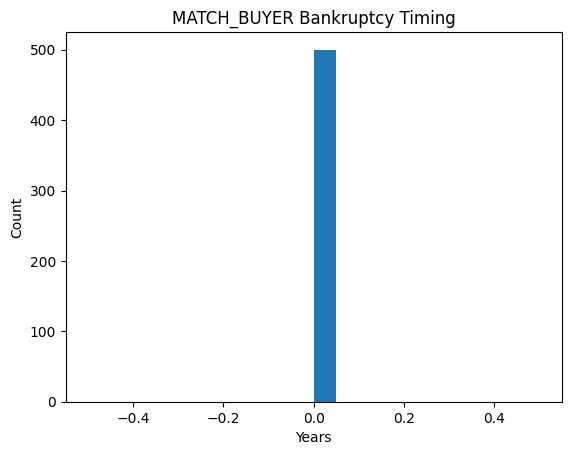

C:\Users\etjdr\AppData\Local\Temp\ipykernel_14460\2445682148.py:77: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



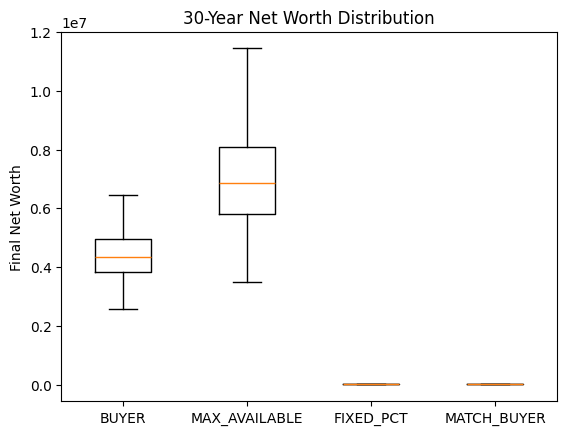

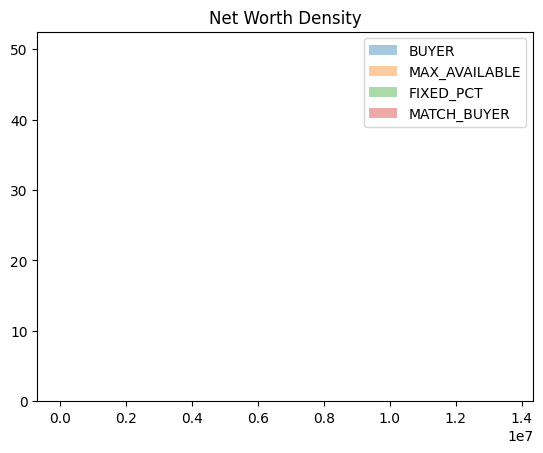

BUYER 4443648.891321646
MAX_AVAILABLE 7085961.025312915
FIXED_PCT nan
MATCH_BUYER nan


In [ ]:
import matplotlib.pyplot as plt

engine = ExtendedSimulationEngine(
    rent=RentParams(
        start_rent=2800,
        growth=0.03
    ),
    years=30,
    market=MarketParams(0.06, 0.08, 0.02),
    income=IncomeParams(150000, 0.03, 0.30),
    living=LivingCostParams(1000, 0.02),
    property_p=PropertyParams(
        price=650000,
        down_pct=0.10,
        mortgage_rate=0.045,
        amort_years=30,
        appreciation=0.03,
        property_tax_rate=0.0061,
        condo_fee=650,
        maintenance_pct=0.005,
        selling_cost_pct=0.05
    ),
    accounts=RegisteredAccountRules(
        tfsa_start_room=80000,
        tfsa_annual_room=7000,
        rrsp_start_room=50000,
        rrsp_max_annual=32000,
        rrsp_pct_income=0.18
    ),
    assessment_risk=AssessmentRisk(0.02, 0.03, 5000, 35000)
)

bankruptcy_policy = BankruptcyPolicy(
    min_liquidity=5000,
    max_debt_ratio=6
)

results, bankruptcies = run_cohort(
    engine,
    runs=500,
    renter_strategies=[
        RenterStrategy.MAX_AVAILABLE,
        RenterStrategy.FIXED_PCT,
        RenterStrategy.MATCH_BUYER
    ],
    bankruptcy_policy=bankruptcy_policy
)

summary = pd.DataFrame([
    summarize_strategy(k, results[k], bankruptcies[k])
    for k in results.keys()
])

summary.sort_values("Median Net Worth", ascending=False)

buyer = np.array(results["BUYER"])

for s in ["MAX_AVAILABLE", "FIXED_PCT", "MATCH_BUYER"]:
    renter = np.array(results[s])
    print(s, f"{np.mean(renter > buyer)*100:.1f}%")


np.median(survivors_only(
    results["MATCH_BUYER"],
    bankruptcies["MATCH_BUYER"]
))

bk_months = [
    b for b in bankruptcies["MATCH_BUYER"] if b is not None
]

plt.hist(np.array(bk_months)/12, bins=20)
plt.xlabel("Years")
plt.ylabel("Count")
plt.title("MATCH_BUYER Bankruptcy Timing")
plt.show()

data = [results[k] for k in results.keys()]
labels = list(results.keys())

plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel("Final Net Worth")
plt.title("30-Year Net Worth Distribution")
plt.show()

for k, v in results.items():
    plt.hist(v, bins=50, alpha=0.4, density=True, label=k)

plt.legend()
plt.title("Net Worth Density")
plt.show()

for k in results.keys():
    print(k, survival_adjusted_value(results[k], bankruptcies[k]))
